#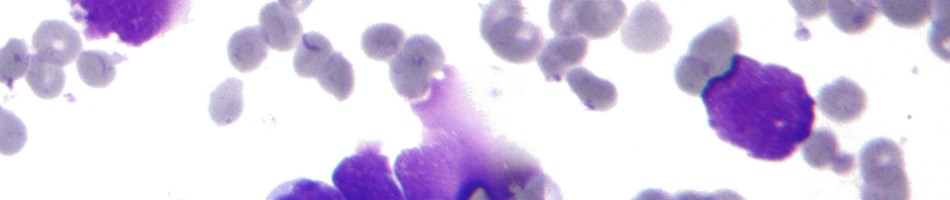
#**Breast Cancer Wisconsin (Diagnostic)**
Predict whether the cancer is benign or malignant

---

> Este é um projeto de Ciência de Dados que tem como objetivo desenvolver um modelo de máquina preditiva para prever, com base nas características das variáveis, se o câncer é benigno ou maligno. A capacidade de identificar com precisão o tipo de câncer com base em dados clinicamente relevantes é de extrema importância na área da saúde, uma vez que orienta decisões de tratamento e cuidados médicos.


#**CRISP-DM (Cross-Industry Standard Process for Data Mining)**

---


> Para atingir esse objetivo, adotamos o framework CRISP-DM (Cross-Industry Standard Process for Data Mining), amplamente reconhecido e utilizado na área de Ciência de Dados devido à sua estrutura organizada e abordagem sistemática. O CRISP-DM nos proporciona um roteiro claro e flexível para lidar com problemas complexos de análise de dados, garantindo que abordemos cada etapa do processo com rigor e compreensão.





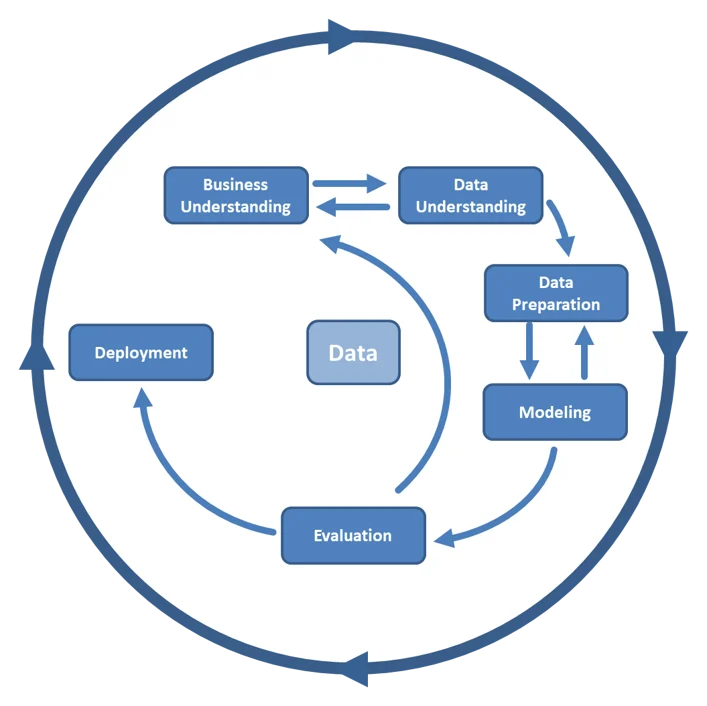

##**BUSINESS UNDERSTANDING**

---





> O objetivo primordial deste projeto de Ciência de Dados é desenvolver um modelo de máquina preditiva para a classificação de casos de câncer de mama como benignos ou malignos

> O diagnóstico preciso de câncer de mama é fundamental para garantir tratamentos adequados e oportunos, aumentando as chances de recuperação e sobrevivência dos pacientes.

> O modelo previsto deve ser capaz de avaliar pacientes com base nas características calculadas a partir de uma imagem digitalizada de um aspirado com agulha fina (PAAF) de uma massa mamária. Eles descrevem características dos núcleos celulares presentes na imagem.

> O espaço tridimensional é aquele descrito em: [KP Bennett e OL Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

##**DATA UNDERSTANDING**

---



Fonte de dados:

Dataset está disponível através do servidor FTP UW CS ftp

ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Também pode ser encontrado no UCI Machine Learning Repository:

https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsi+%28Diagnostic%29

No Kaggle:

https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

### **Import Library**

---

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder
from sklearn.metrics         import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.tree            import DecisionTreeClassifier

# Montar o Google Drive para acessar arquivos
from google.colab import drive
drive.mount('/content/drive')


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Mounted at /content/drive


###**Functions**

---

In [3]:
def pod_academy_generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

def pod_custom_fillna(df):
    import pandas as pd

    import numpy as np
    # Substituindo -1 por nulos
    # Esta função serve para este modelo ou caso específico, porque pode ser que em outras situações o missing não venha marcado com -1

    numerical_cols = df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    means = {}

    for col in numerical_cols:
        means[col] = df[col].mean()
        df[col].fillna(means[col], inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('DESCONHECIDO')

    return df, means

def pod_custom_fillna_prod(df, means):
    import numpy as np
    import pandas as pd
    df.replace(-1, np.nan, inplace=True)
    for col, mean_value in means.items():
      df[col].fillna(mean_value, inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('DESCONHECIDO')

    return df


def gini_normalizado(y_true, y_pred):
    import pandas as pd
    import numpy as np
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

def avaliar_modelo(X_train, y_train, X_test, y_test, modelo, nm_modelo):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score

    feature_names = list(X_train.columns)
    # Criação da figura e dos eixos
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))  # Ajustado para incluir novos gráficos
    plt.tight_layout(pad=6.0)

    # Cor azul claro
    cor = 'skyblue'

    # Taxa de Evento e Não Evento
    event_rate = np.mean(y_train)
    non_event_rate = 1 - event_rate
    axs[0, 0].bar(['Evento', 'Não Evento'], [event_rate, non_event_rate], color=[cor, 'lightcoral'])
    axs[0, 0].set_title('Taxa de Evento e Não Evento')
    axs[0, 0].set_ylabel('Proporção')

    # Importância dos Atributos
    importancias = None
    if hasattr(modelo, 'coef_'):
        importancias = np.abs(modelo.coef_[0])
    elif hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_

    if importancias is not None:
        importancias_df = pd.DataFrame({'feature': feature_names, 'importance': importancias})
        importancias_df = importancias_df.sort_values(by='importance', ascending=True)

        axs[0, 1].barh(importancias_df['feature'], importancias_df['importance'], color=cor)
        axs[0, 1].set_title('Importância das Variáveis - ' + nm_modelo)
        axs[0, 1].set_xlabel('Importância')

    else:
        axs[0, 1].axis('off')  # Desativa o subplot se não houver importâncias para mostrar

    # Confusion Matrix - Treino
    y_pred_train = modelo.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    axs[1, 0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 0].set_title('Confusion Matrix - Treino - ' + nm_modelo)
    axs[1, 0].set_xticks([0, 1])
    axs[1, 0].set_yticks([0, 1])
    axs[1, 0].set_xticklabels(['0', '1'])
    axs[1, 0].set_yticklabels(['0', '1'])
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        axs[1, 0].text(j, i, format(cm_train[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

    # Confusion Matrix - Teste
    y_pred_test = modelo.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    axs[1, 1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 1].set_title('Confusion Matrix - Teste - ' + nm_modelo)
    axs[1, 1].set_xticks([0, 1])
    axs[1, 1].set_yticks([0, 1])
    axs[1, 1].set_xticklabels(['0', '1'])
    axs[1, 1].set_yticklabels(['0', '1'])
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        axs[1, 1].text(j, i, format(cm_test[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

    # ROC Curve - Treino e Teste
    y_score_train = modelo.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    axs[2, 0].plot(fpr_train, tpr_train, color=cor, label='Treino')

    y_score_test = modelo.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    axs[2, 0].plot(fpr_test, tpr_test, color='darkorange', label='Teste')

    axs[2, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2, 0].set_title('ROC Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 0].set_xlabel('False Positive Rate')
    axs[2, 0].set_ylabel('True Positive Rate')
    axs[2, 0].legend(loc="lower right")

    # Precision-Recall Curve - Treino e Teste
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
    axs[2, 1].plot(recall_train, precision_train, color=cor, label='Treino')

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    axs[2, 1].plot(recall_test, precision_test, color='darkorange', label='Teste')

    axs[2, 1].set_title('Precision-Recall Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 1].set_xlabel('Recall')
    axs[2, 1].set_ylabel('Precision')
    axs[2, 1].legend(loc="upper right")

    # Gini - Treino e Teste
    auc_train = roc_auc_score(y_train, y_score_train)
    gini_train = 2 * auc_train - 1
    auc_test = roc_auc_score(y_test, y_score_test)
    gini_test = 2 * auc_test - 1
    axs[3, 0].bar(['Treino', 'Teste'], [gini_train, gini_test], color=[cor, 'darkorange'])
    axs[3, 0].set_title('Gini - ' + nm_modelo)
    axs[3, 0].set_ylim(0, 1)
    axs[3, 0].text('Treino', gini_train + 0.01, f'{gini_train:.2f}', ha='center', va='bottom')
    axs[3, 0].text('Teste', gini_test + 0.01, f'{gini_test:.2f}', ha='center', va='bottom')

    # KS - Treino e Teste
    ks_train = calcular_ks_statistic(y_train, y_score_train)
    ks_test = calcular_ks_statistic(y_test, y_score_test)
    axs[3, 1].bar(['Treino', 'Teste'], [ks_train, ks_test], color=[cor, 'darkorange'])
    axs[3, 1].set_title('KS - ' + nm_modelo)
    axs[3, 1].set_ylim(0, 1)
    axs[3, 1].text('Treino', ks_train + 0.01, f'{ks_train:.2f}', ha='center', va='bottom')
    axs[3, 1].text('Teste', ks_test + 0.01, f'{ks_test:.2f}', ha='center', va='bottom')


    # Decile Analysis - Teste
    scores = modelo.predict_proba(X_test)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores.shape)  # Adiciona um pequeno ruído
    scores += noise
    deciles = pd.qcut(scores, q=10, duplicates='drop')
    decile_analysis = y_test.groupby(deciles).mean()
    axs[4, 1].bar(range(1, len(decile_analysis) + 1), decile_analysis, color='darkorange')
    axs[4, 1].set_title('Ordenação do Score - Teste - ' + nm_modelo)
    axs[4, 1].set_xlabel('Faixas de Score')
    axs[4, 1].set_ylabel('Taxa de Evento')

    # Decile Analysis - Treino
    scores_train = modelo.predict_proba(X_train)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores_train.shape)  # Adiciona um pequeno ruído
    scores_train += noise
    deciles_train = pd.qcut(scores_train, q=10, duplicates='drop')
    decile_analysis_train = y_train.groupby(deciles_train).mean()
    axs[4, 0].bar(range(1, len(decile_analysis_train) + 1), decile_analysis_train, color=cor)
    axs[4, 0].set_title('Ordenação do Score - Treino - ' + nm_modelo)
    axs[4, 0].set_xlabel('Faixas de Score')
    axs[4, 0].set_ylabel('Taxa de Evento')

    # Mostrar os gráficos
    plt.show()

def calcular_ks_statistic(y_true, y_score):
    import pandas as pd
    import numpy as np
    df = pd.DataFrame({'score': y_score, 'target': y_true})
    df = df.sort_values(by='score', ascending=False)
    total_events = df.target.sum()
    total_non_events = len(df) - total_events
    df['cum_events'] = df.target.cumsum()
    df['cum_non_events'] = (df.target == 0).cumsum()
    df['cum_events_percent'] = df.cum_events / total_events
    df['cum_non_events_percent'] = df.cum_non_events / total_non_events
    ks_statistic = np.abs(df.cum_events_percent - df.cum_non_events_percent).max()
    return ks_statistic



def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

   # Calculando o Índice Gini e Estatística KS para o conjunto de teste

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df



def _plot_metrics(y_test,predictions):
    Accuracy= accuracy_score(y_test, predictions)
    Recall= recall_score(y_test, predictions)
    Precision= precision_score(y_test, predictions)

    return Accuracy, Recall, Precision



### **Definições de pastas**

In [30]:
# Diretório dataset
file_folder_dataset_input = '/content/drive/MyDrive/EDA/exame_mama/data.csv'

# diretório para salvar artefatos dataprep

file_folder_pkl_fdrop_nullvars    = '/content/drive/MyDrive/EDA/exame_mama/dataprep/prd_drop_nullvars.pkl'
file_folder_pkl_fillna            = '/content/drive/MyDrive/EDA/exame_mama/dataprep/prd_fillna.pkl'
file_folder_pkl_labelenc          = '/content/drive/MyDrive/EDA/exame_mama/dataprep/prd_labelenc.pkl'
file_folder_pkl_onehotenc         = '/content/drive/MyDrive/EDA/exame_mama/dataprep/prd_onehotenc.pkl'
file_folder_pkl_scaler            = '/content/drive/MyDrive/EDA/exame_mama/dataprep/prd_scaler.pkl'
file_folder_pkl_list_features     = '/content/drive/MyDrive/EDA/exame_mama/dataprep/prd_list_features.pkl'
file_folder_pkl_list_features_pca = '/content/drive/MyDrive/EDA/exame_mama/dataprep/prd_list_features_pca.pkl'

# diretório para salvar artefatos modelos

file_folder_best_model_rl_fs                  = '/content/drive/MyDrive/EDA/exame_mama/model/best_model_rl_fs.pkl'
file_folder_best_model_rl_pca                 = '/content/drive/MyDrive/EDA/exame_mama/model/best_model_rl_pca.pkl'
file_folder_best_model_dt_fs                  = '/content/drive/MyDrive/EDA/exame_mama/model/best_model_dt_fs.pkl'
file_folder_best_model_dt_pca                 = '/content/drive/MyDrive/EDA/exame_mama/model/best_model_dt_pca.pkl'
file_folder_best_model_rf_fs                  = '/content/drive/MyDrive/EDA/exame_mama/model/best_model_rf_fs.pkl'
file_folder_best_model_rf_pca                 = '/content/drive/MyDrive/EDA/exame_mama/model/best_model_rf_pca.pkl'

### **Load**

---

In [4]:
df_00 = pd.read_csv(file_folder_dataset_input)
print(df_00.shape)

df_00['diagnosis'] = df_00['diagnosis'].replace({'B': 0, 'M': 1})
df_00['diagnosis'] = df_00['diagnosis'].astype(int)


(569, 33)


### **Split**

In [6]:
# Dividindo o DataFrame em treino e teste
df_train_00, df_test_00 = train_test_split(df_00, test_size=0.3, random_state=42)

df_train_00.shape,df_test_00.shape

((398, 33), (171, 33))

## **DATA PREPARATION**

Preparação dos Dados para gerar a ABT (Tabela Analítica de Modelagem)


*   Remoção de variáveis para o tratamento dos dados
*   Geração dos metadados
*   Tratamento de valores nulos
*   Tratamento de categóricas de alta cardinalidade (LabelEncoder)
*   Tratamento de categóricas de baixa cardinalidade (OneHotEncoder)




### **Lista de vars para retirar do tratamento**

---

In [7]:
# lista de vars para retirar dos tratamentos

lista_spec = ['id', 'diagnosis']

df_train_01 = df_train_00.drop(axis=1,columns = lista_spec)
df_train_01.shape

(398, 31)

### **Metadados**

---

In [8]:
# Gera metadados
df_train_01
metadata_df = pod_academy_generate_metadata(df_train_01)
metadata_df.head(100)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,Unnamed: 32,float64,398,100.0,0
1,concavity_se,float64,0,0.0,382
2,fractal_dimension_worst,float64,0,0.0,380
3,symmetry_worst,float64,0,0.0,368
4,concave points_worst,float64,0,0.0,350
5,concavity_worst,float64,0,0.0,383
6,compactness_worst,float64,0,0.0,378
7,smoothness_worst,float64,0,0.0,316
8,area_worst,float64,0,0.0,383
9,perimeter_worst,float64,0,0.0,367


### **Trata valores nulos**

---


In [9]:
# Variáveis numéricas
missing_cutoff = 70
drop_vars_nulos = metadata_df[(metadata_df['percent_nulos'] >= missing_cutoff)]
lista_drop_vars = list(drop_vars_nulos.nome_variavel.values)

print('Variáveis que serão excluídas por alto percentual de nulos: ',lista_drop_vars)
# retirando lista de variáveis com alto percentual de nulos
df_train_02 = df_train_01.drop(axis=1,columns=lista_drop_vars)
df_train_02.shape

# Salvar a lista em um arquivo .pkl
with open(file_folder_pkl_fdrop_nullvars, 'wb') as f:
    pickle.dump(lista_drop_vars, f)

Variáveis que serão excluídas por alto percentual de nulos:  ['Unnamed: 32']


### **Substituindo os nulos**

---


In [10]:

# Média para variáveis numéricas

# MISS_VERIFICAR" para categóricas

#calcula média de cada variável
df_train_03, means = pod_custom_fillna(df_train_02)

# Salvar artefatos fillna
with open(file_folder_pkl_fillna, 'wb') as f:
  pickle.dump(means, f)

# recupera artefatos para aplicar na base de teste
with open(file_folder_pkl_fillna, 'rb') as f:
  loaded_means = pickle.load(f)
loaded_means

# Aplicar na base de teste
df_test_00 = pod_custom_fillna_prod(df_test_00,loaded_means)
df_test_00.shape

(171, 33)

###**Tratamento de categóricas de alta cardinalidade (LabelEncoder)**

---

In [11]:
card_cutoff = 2
df_categ_labelenc = metadata_df[(metadata_df['cardinalidade'] > card_cutoff) & (metadata_df['tipo'] == 'object')]
lista_vars_abt = list(df_train_03.columns)
lista_lenc = list(df_categ_labelenc.nome_variavel.values)

for item in lista_drop_vars:
    if item in lista_lenc:
        lista_lenc.remove(item)

print('Lista de vars para Label Encoding: ',lista_lenc)

encoders = {}

for col in lista_lenc:
    encoder = LabelEncoder()
    df_train_02[col] = encoder.fit_transform(df_train_02[col])

    # Armazena o encoder para a coluna atual em um dicionário
    encoders[col] = encoder

# Salva o dicionário de encoders e a lista de colunas em um arquivo .pkl
data_to_serialize = {
    'encoders': encoders,
    'columns': lista_lenc
}

with open(file_folder_pkl_labelenc, 'wb') as f:
    pickle.dump(data_to_serialize, f)


# Carregar os encoders e a lista de colunas
with open(file_folder_pkl_labelenc, 'rb') as f:
    loaded_data = pickle.load(f)

loaded_encoders = loaded_data['encoders']
loaded_columns = loaded_data['columns']

# Suponha test_df como sua base de teste
for col in loaded_columns:
    if col in loaded_encoders:
        # Transforma a coluna usando o encoder carregado
        df_test_00[col] = loaded_encoders[col].transform(df_test_00[col])

Lista de vars para Label Encoding:  []


### **Tratamento de categóricas baixa cardinalidade (OneHotEncoder)**

---

In [12]:
import pickle
from sklearn.preprocessing import OneHotEncoder

card_cutoff = 2
df_categ_onehot = metadata_df[(metadata_df['cardinalidade'] <= card_cutoff) & (metadata_df['tipo'] == 'object')]
lista_onehot = list(df_categ_onehot.nome_variavel.values)
print('Lista de vars para OneHot Encoding: ',lista_onehot)

# Instanciando o encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Aplicando o one-hot encoding
encoded_data = encoder.fit_transform(df_train_03[lista_onehot])
encoded_cols = encoder.get_feature_names_out(lista_onehot)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_train_03.index)

df_train_04 = pd.concat([df_train_03.drop(lista_onehot, axis=1), encoded_df], axis=1)

# Salva o encoder e a lista de colunas em um arquivo .pkl
data_to_serialize = {
    'encoder': encoder,
    'columns': lista_onehot
}


with open(file_folder_pkl_onehotenc, 'wb') as f:
    pickle.dump(data_to_serialize, f)


# Carregar o encoder e a lista de colunas
with open(file_folder_pkl_onehotenc, 'rb') as f:
    loaded_data = pickle.load(f)

loaded_encoder = loaded_data['encoder']
loaded_columns = loaded_data['columns']

# Suponha test_df como sua base de teste
encoded_data_test = loaded_encoder.transform(df_test_00[loaded_columns])
encoded_cols_test = loaded_encoder.get_feature_names_out(loaded_columns)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_cols_test, index=df_test_00.index)

df_test_01 = pd.concat([df_test_00.drop(loaded_columns, axis=1), encoded_df_test], axis=1)

Lista de vars para OneHot Encoding:  []


##**MODELING**

### **Feature Selection**

---

O processo de Feature Selection é uma etapa fundamental na preparação e modelagem de dados em ciência de dados e aprendizado de máquina. Consiste em selecionar um subconjunto das características (features) mais relevantes e informativas dos dados para construir modelos preditivos mais eficazes.

Nesse contexto, foram geradas duas versões da nossa tabela de dados (ABT):

1.   Aplicação do algoritmo GradientBoostingClassifier para calcular a importância de cada feature no processo de classificação.
2.   Técnica de Análise de Componentes Principais (PCA) para redução de dimensionalidade




#### **Feature Importance**


 Foi realizado testes com três algoritmos de seleção de features:

 1. GradientBoostingClassifier
 2. DecisionTreeClassifier
 3. RandomForestClassifier

O objetivo desses testes foi identificar as features mais relevantes em nosso conjunto de dados.

Após a análise comparativa dos três algoritmos de seleção de features, o **GradientBoostingClassifier** demonstrou um desempenho superior na identificação das features mais relevantes para a tarefa de classificação.

In [13]:
# Criando ABT Treino
abt_train = df_train_04.merge(df_train_00[['id','diagnosis']], left_index=True, right_index=True, how='inner')

# Criando ABT Teste
list_columns_drop = ['id','Unnamed: 32']
abt_test = df_test_01.drop(axis=1,columns=list_columns_drop)

Número de features selecionadas:  6


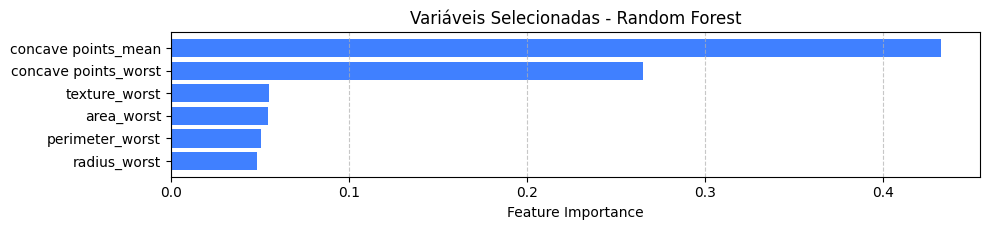

['concave points_mean', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


In [14]:
# Treinar modelo com algoritmo GradientBoostingClassifier
X = abt_train.drop(axis=1,columns='diagnosis')
y = abt_train.diagnosis

clf = GradientBoostingClassifier() # troque aqui qual classificador quer utilizar: GradientBoostingClassifier, DecisionTreeClassifier,RandomForestClassifier
clf.fit(X, y)

# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff_maximp = 0.1

cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = X.columns[feature_importances > cutoff].tolist()
print('Número de features selecionadas: ',len(selected_features))

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=True)

# Filtrar o DataFrame para apenas as features acima do corte
selected_features_df = features[features['Importance'] > cutoff]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas - Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Salvar a lista em um arquivo .pkl
import pickle
with open(file_folder_pkl_list_features, 'wb') as f:
    pickle.dump(selected_features, f)

# Carregar a lista do arquivo .pkl
with open(file_folder_pkl_list_features, 'rb') as f:
    loaded_lista = pickle.load(f)

print(loaded_lista)


##### **Aplicando artefatos**

In [15]:
# Criando ABT Treino com as variáveis selecionadas
lista_features = loaded_lista + ['diagnosis']
abt_01 = abt_train[lista_features]
abt_01.head()


# Criando ABT Teste com as variáveis selecionadas
lista_features = loaded_lista + ['diagnosis']
abt_01_test = abt_test[lista_features]

abt_01_test.head()

,concave points_mean,radius_worst,texture_worst,perimeter_worst,area_worst,concave points_worst,diagnosis
204,0.03821,14.97,24.64,96.05,677.9,0.10150,0
70,0.07951,24.86,26.58,165.90,1866.0,0.17890,1
131,0.08087,19.26,26.00,124.90,1156.0,0.15140,1
431,0.02799,12.88,22.91,89.61,515.8,0.07370,0
540,0.02594,12.26,19.68,78.78,457.8,0.06918,0


##### **Salvando e criando ABT**

#### **PCA**

In [16]:
# Aplicando padronização dos Dados
X = df_train_04
features = X.columns

# Padronizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicando PCA
pca = PCA(n_components=None) # Se None todos componentes vão ficar mantidos
pca.fit(X_scaled)

# Extraindo as cargas e criando um DataFrame
loadings = pca.components_
loading_df = pd.DataFrame(loadings, columns=features, index=['PC'+str(i) for i in range(1, loadings.shape[0]+1)])
loading_df_transposed = loading_df.transpose()

loading_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
PC1,0.216927,0.106841,0.226026,0.219594,0.141974,0.238731,0.260357,0.263648,0.148065,0.058694,...,0.226308,0.107381,0.236046,0.223943,0.125357,0.207062,0.232988,0.252293,0.122468,0.125055
PC2,-0.237700,-0.044474,-0.220103,-0.233867,0.179887,0.158836,0.059628,-0.037974,0.179719,0.360696,...,-0.223346,-0.032596,-0.203184,-0.221855,0.170141,0.153409,0.098852,-0.002558,0.121710,0.284607
PC3,-0.009763,0.063888,-0.010380,0.026276,-0.126396,-0.072800,0.004566,-0.038050,-0.046923,-0.020246,...,-0.054419,-0.050009,-0.054778,-0.019510,-0.280698,-0.230659,-0.169829,-0.182134,-0.285881,-0.221250
PC4,-0.041359,0.605147,-0.043286,-0.058593,-0.129320,-0.041936,-0.039805,-0.063297,-0.017263,-0.074808,...,-0.012589,0.640635,-0.010395,-0.029068,-0.007324,0.076855,0.041477,0.003727,0.066975,0.022767
PC5,0.046919,-0.003762,0.047118,0.012485,-0.395103,0.013418,0.091664,-0.047019,-0.267022,-0.063646,...,0.009945,-0.038106,0.025420,-0.016860,-0.323525,0.137980,0.200747,0.046523,-0.202370,0.085451
PC6,0.031479,-0.073587,0.026766,0.001321,-0.263985,-0.026666,-0.028050,-0.042995,0.356531,-0.134412,...,0.004438,-0.077005,0.009614,-0.032392,-0.339046,0.045410,0.006410,-0.014648,0.513299,-0.076446
PC7,-0.152206,0.026822,-0.141691,-0.081854,-0.125648,0.015819,-0.089791,-0.181304,-0.103132,0.254623,...,-0.038205,0.045715,-0.022738,0.031095,-0.105803,0.164340,0.001942,-0.144439,0.009782,0.345045
PC8,0.040138,0.076101,0.031993,0.081645,-0.281305,-0.083350,-0.082013,-0.106062,-0.364201,-0.106141,...,0.057026,0.002940,0.052171,0.092366,0.163485,0.166628,0.041753,-0.045556,0.166855,0.117193
PC9,-0.188213,0.260384,-0.184746,-0.182339,-0.052617,-0.096165,-0.028015,-0.082519,0.205366,-0.192434,...,-0.108511,0.057668,-0.095149,-0.104157,0.126863,-0.022611,0.058969,0.106230,0.100497,-0.204087
PC10,0.057657,0.000568,0.036344,0.100908,-0.215223,-0.211563,-0.062963,-0.094113,0.535100,0.045295,...,0.121340,0.036904,0.074323,0.185116,0.026732,-0.219877,-0.113340,-0.122270,0.139436,0.133973


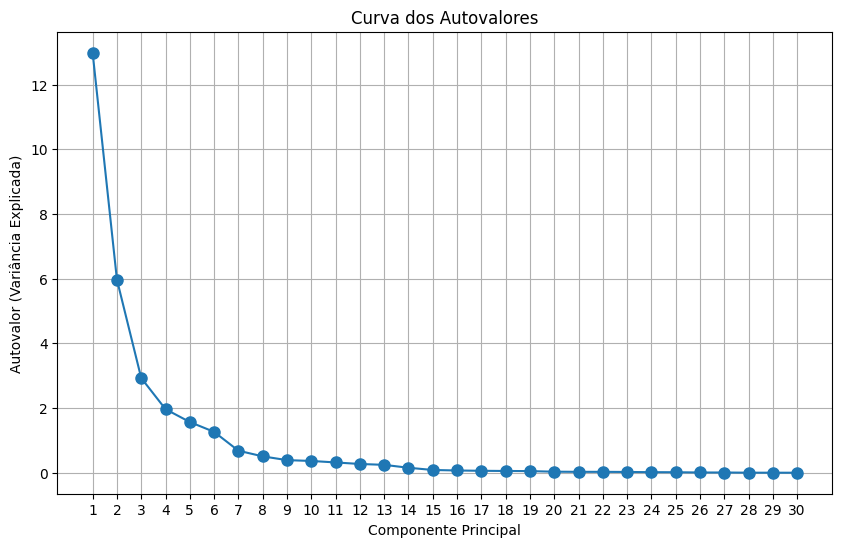

In [17]:
# Obtendo os autovalores (explicados pela variância) dos componentes principais
eigenvalues = pca.explained_variance_

# Plotando a curva dos autovalores
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, 'o-', markersize=8)
plt.xlabel('Componente Principal')
plt.ylabel('Autovalor (Variância Explicada)')
plt.title('Curva dos Autovalores')
plt.xticks(range(1, len(eigenvalues)+1))
plt.grid(True)
plt.show()


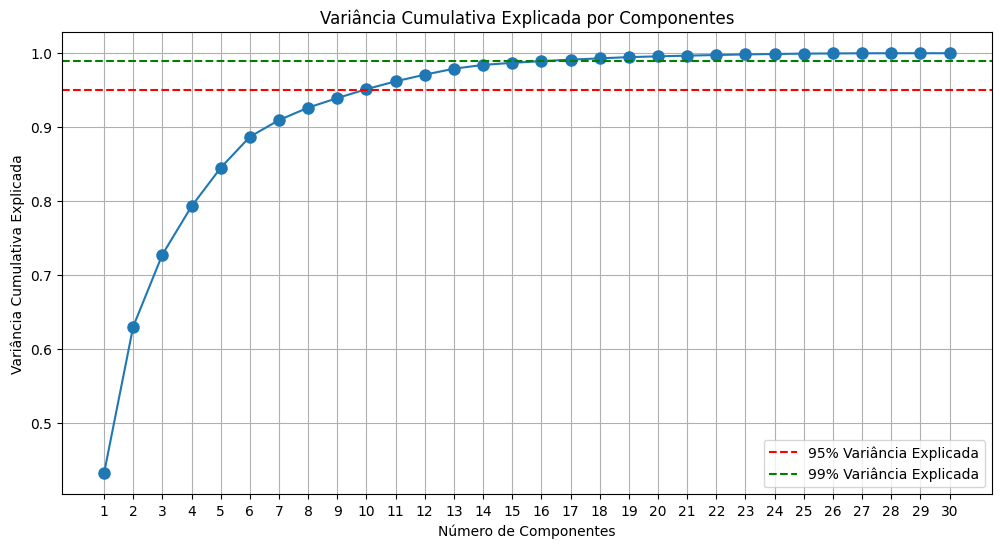

In [18]:
# Calculando a variância cumulativa
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plotando a variância cumulativa
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, 'o-', markersize=8)
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Cumulativa Explicada')
plt.title('Variância Cumulativa Explicada por Componentes')
plt.xticks(range(1, len(cumulative_variance_ratio)+1))
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variância Explicada')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Variância Explicada')
plt.legend(loc='best')
plt.show()

In [19]:
# Aplicando PCA para selecionar variáveis
pca = PCA(n_components=15) # Se None todos componentes vão ficar mantidos
pca.fit(X_scaled)

# Extraindo as cargas e criando um DataFrame
loadings = pca.components_
loading_df = pd.DataFrame(loadings, columns=features, index=['PC'+str(i) for i in range(1, loadings.shape[0]+1)])
loading_df_transposed = loading_df.transpose()
loading_df_transposed

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
radius_mean,0.216927,-0.237700,-0.009763,-0.041359,0.046919,0.031479,-0.152206,0.040138,-0.188213,0.057657,-0.086714,0.063642,0.012218,0.078957,0.123920
texture_mean,0.106841,-0.044474,0.063888,0.605147,-0.003762,-0.073587,0.026822,0.076101,0.260384,0.000568,-0.276128,0.339703,0.191472,-0.003043,0.134022
perimeter_mean,0.226026,-0.220103,-0.010380,-0.043286,0.047118,0.026766,-0.141691,0.031993,-0.184746,0.036344,-0.104370,0.047121,0.038407,0.057553,0.108243
area_mean,0.219594,-0.233867,0.026276,-0.058593,0.012485,0.001321,-0.081854,0.081645,-0.182339,0.100908,-0.034013,0.069044,0.068767,0.037327,0.054096
smoothness_mean,0.141974,0.179887,-0.126396,-0.129320,-0.395103,-0.263985,-0.125648,-0.281305,-0.052617,-0.215223,-0.027020,0.237237,0.095581,0.490304,0.137210
compactness_mean,0.238731,0.158836,-0.072800,-0.041936,0.013418,-0.026666,0.015819,-0.083350,-0.096165,-0.211563,-0.345855,-0.088399,0.163557,-0.027557,-0.251270
concavity_mean,0.260357,0.059628,0.004566,-0.039805,0.091664,-0.028050,-0.089791,-0.082013,-0.028015,-0.062963,0.186371,0.028766,0.416425,-0.260506,0.024710
concave points_mean,0.263648,-0.037974,-0.038050,-0.063297,-0.047019,-0.042995,-0.181304,-0.106062,-0.082519,-0.094113,-0.060754,0.075475,0.117940,-0.279951,0.072100
symmetry_mean,0.148065,0.179719,-0.046923,-0.017263,-0.267022,0.356531,-0.103132,-0.364201,0.205366,0.535100,-0.246437,-0.243845,0.180025,-0.012842,0.149094
fractal_dimension_mean,0.058694,0.360696,-0.020246,-0.074808,-0.063646,-0.134412,0.254623,-0.106141,-0.192434,0.045295,-0.161303,0.282176,0.047410,-0.312250,-0.499234


In [20]:
x = 1  # Por exemplo, vamos pegar a primeira variável de maior loading absoluto para cada componente

# Identificando as 'x' variáveis de maior loading absoluto para cada componente
top_loadings = {}

for component in loading_df_transposed.columns:
    sorted_loadings = loading_df_transposed[component].abs().sort_values(ascending=False)
    top_loadings[component] = sorted_loadings.index[:x].tolist()

# Gerando uma lista única de variáveis de top loadings de todos os componentes
unique_top_loadings = list(set([item for sublist in top_loadings.values() for item in sublist]))

In [21]:
# Salvar a lista em um arquivo .pkl
import pickle
with open(file_folder_pkl_list_features_pca, 'wb') as f:
    pickle.dump(unique_top_loadings, f)

# Carregar a lista do arquivo .pkl
with open(file_folder_pkl_list_features_pca, 'rb') as f:
    loaded_lista_pca = pickle.load(f)

print(loaded_lista_pca)


['smoothness_se', 'symmetry_mean', 'fractal_dimension_mean', 'smoothness_mean', 'concave points_se', 'texture_worst', 'area_se', 'texture_se', 'symmetry_se', 'concave points_mean', 'concavity_se']


In [22]:
# Aplicando a seleção das variáveis PCA na base de treino
lista_features_pca = unique_top_loadings + ['diagnosis']
abt_01_pca = abt_train[lista_features_pca]
abt_01_pca.head()

# Aplicando a seleção das variáveis PCA na base de teste
lista_features_pca = unique_top_loadings + ['diagnosis']
abt_01_pca_test = abt_test[lista_features_pca]


In [23]:
# Separando as variáveis de entrada (features) e de saída (target) - Feature Importante
X_fs = abt_01.drop(columns=["diagnosis"])
y_fs = abt_01["diagnosis"]

# Separando as variáveis de entrada (features) e de saída (target) - PCA
X_pca = abt_01_pca.drop(columns=["diagnosis"])
y_pca = abt_01_pca["diagnosis"]

### **Train Model**

Nesta fase da análise de desempenho, utilizamos três algoritmos de classificação amplamente reconhecidos:

* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier.

O objetivo inicial foi avaliar o desempenho desses algoritmos em nosso conjunto de dados, com foco especial nas métricas:
1. **Recall**
2. **Precision**

O **recall** é uma métrica crítica em problemas em que a detecção de casos positivos é de grande importância em diagnóstico médico. Mede a capacidade do modelo em identificar corretamente todos os casos positivos, minimizando falsos negativos.

####**Logistic Regression**

#####**Logistic Regression por Feature Importances**

---
**Treinamento**

In [24]:
# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X_fs,
                                                    y_fs,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

# Definindo o modelo
model = LogisticRegression(max_iter=1000)
model_sgs = LogisticRegression(max_iter=1000)


# Definindo os parâmetros para o grid search
param_grid = {
    'penalty':['l1','l2'],
    'tol':[0.00001,0.0001,0.001],
    'C': [1.0, 2.0],
    'solver':['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}]
}



# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['penalty']) * len(param_grid['tol']) * len(param_grid['C']) * len(param_grid['solver']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='recall',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# treinando modelo sem grid search para comparra
model_sgs.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_rl_fs = grid.best_estimator_

# Salva artefatos
with open(file_folder_best_model_rl_fs, 'wb') as file:
  pickle.dump(best_model_rl_fs, file)


Total de Modelos a serem Treinados: 120
Melhores Parâmetros:  {'C': 2.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
Melhor AUC:  0.96
Gini normalizado -->  0.97


#####**Logistic Regression por Feature Importances**

---
**Métricas**

In [329]:
# Uso da função
metrics_rl_fs = calculate_metrics('LogisticRegression',best_model_rl_fs, X_train, y_train, X_test, y_test)
plot_rl_metrics =  _plot_metrics(y_test,predictions)
metrics_rl_fs


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.964029,0.941176,0.960000,0.992135,0.984270,0.933820
1,LogisticRegression,Teste,0.966667,0.941176,0.979592,0.985628,0.971256,0.937338


In [330]:
plot_rl_metrics

(0.9666666666666667, 0.9795918367346939, 0.9411764705882353)

#####**Logistic Regression por Feature Importances**

---
**Avaliação**

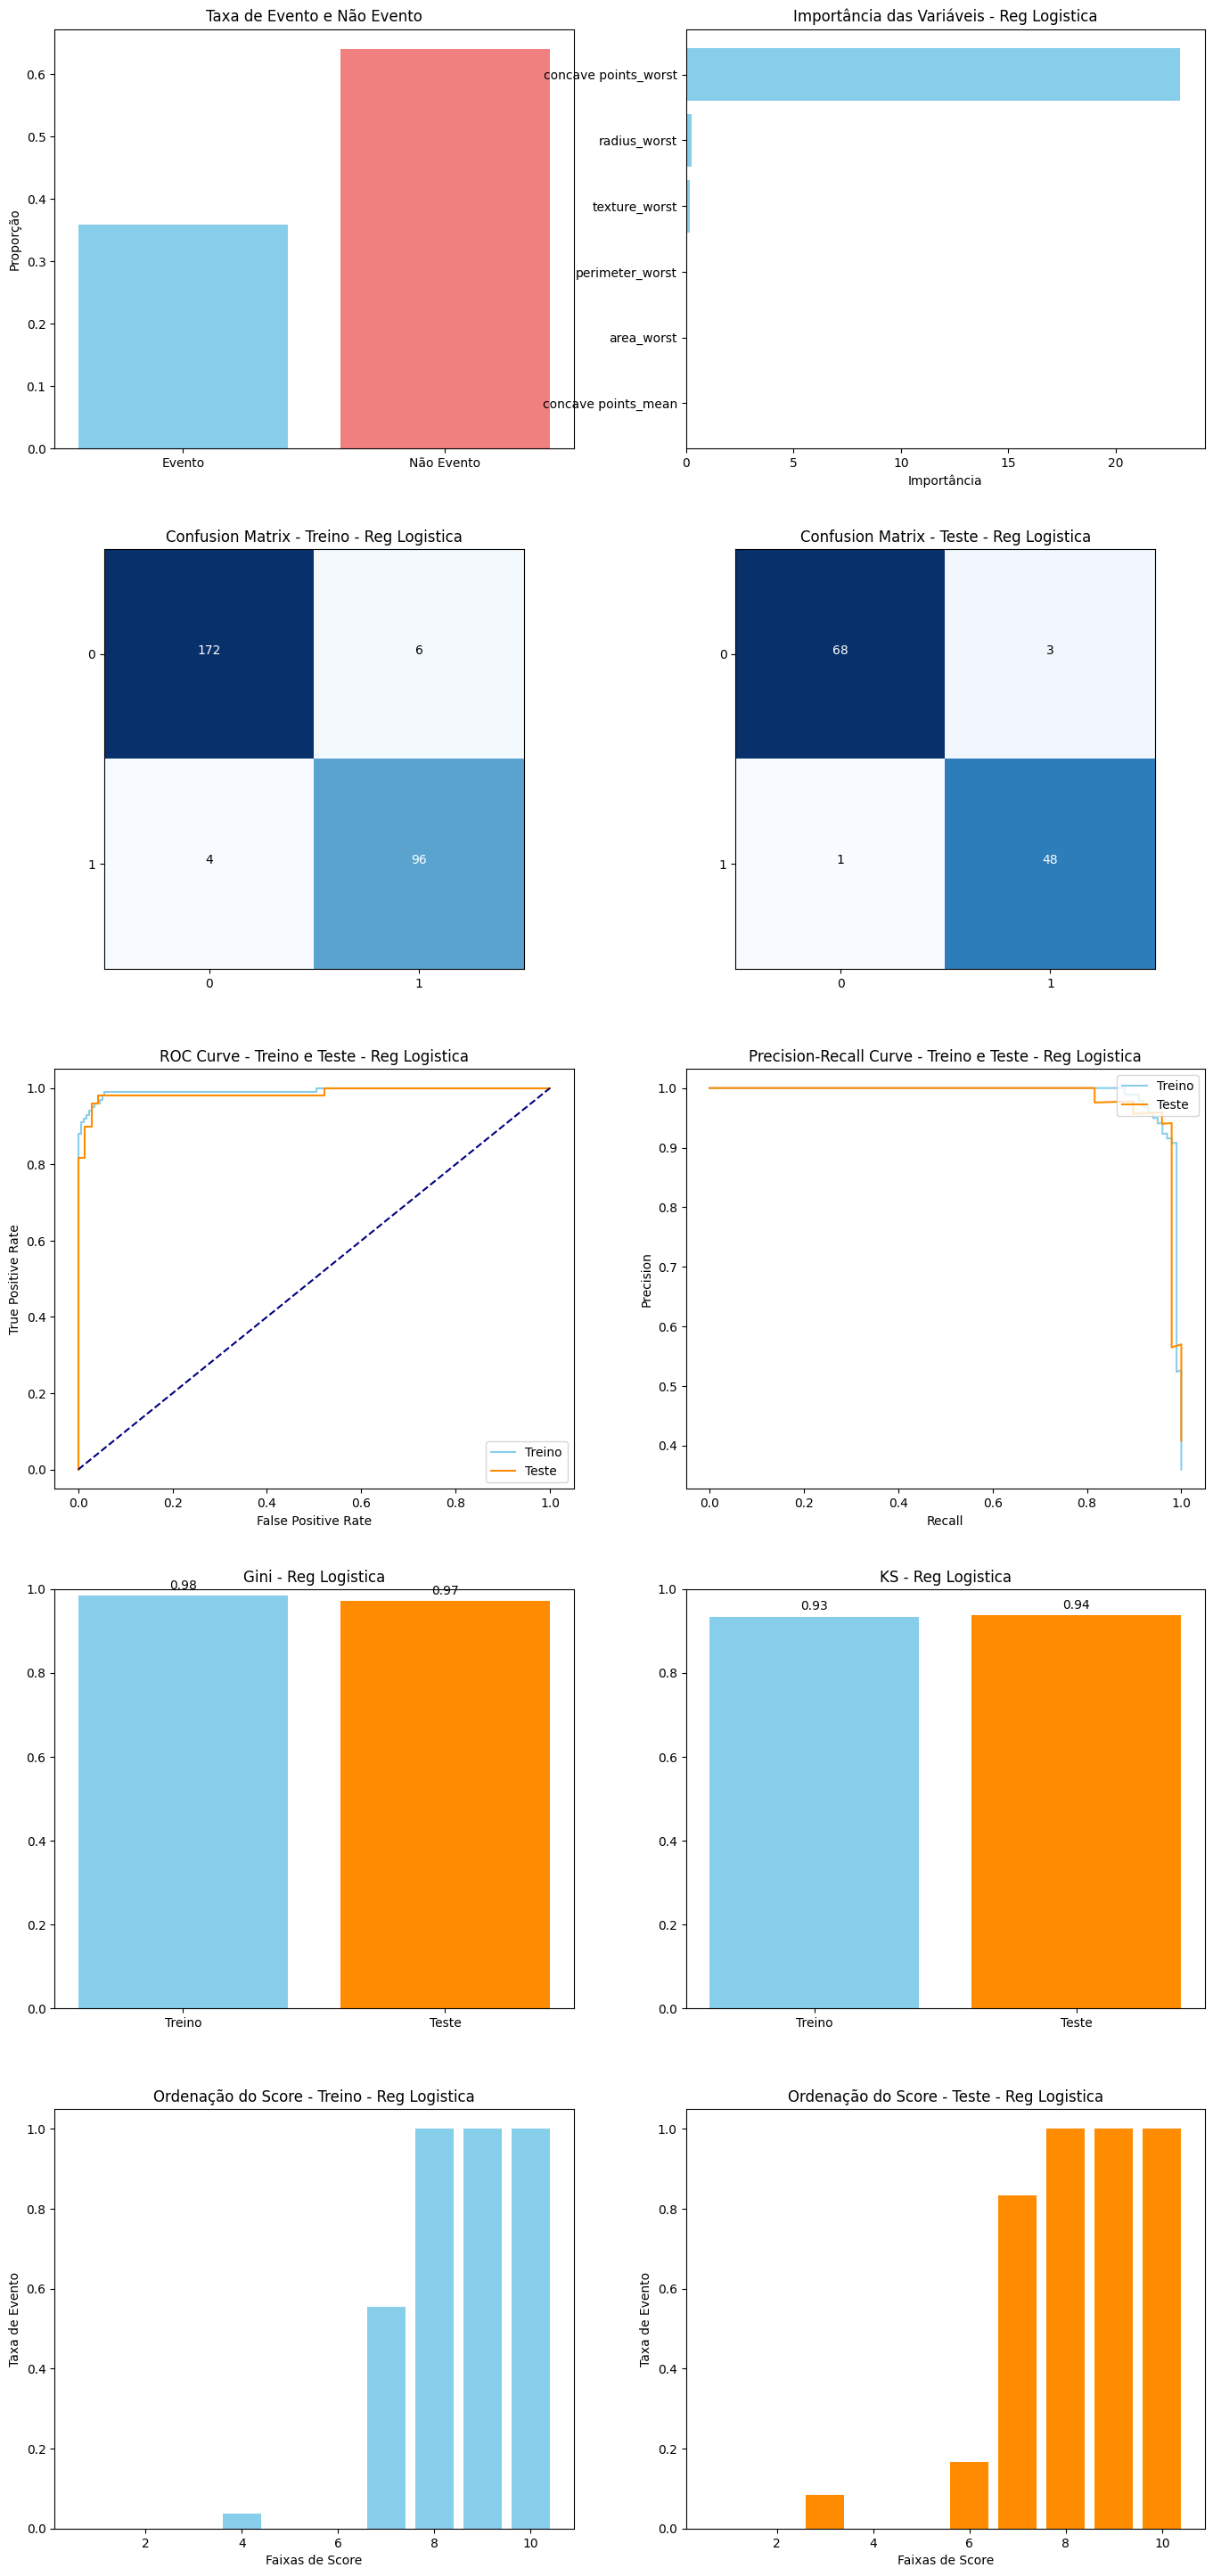

In [331]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rl_fs,nm_modelo='Reg Logistica')

##### **Logistic Regression por PCA**

---
**Treinamento**

In [332]:

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X_pca,
                                                    y_pca,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

# Definindo o modelo
model = LogisticRegression(max_iter=100)
model_sgs = LogisticRegression(max_iter=100)


param_grid = {
    'penalty':['l1','l2'],
    'tol':[0.00001,0.0001,0.001],
    'C': [1.0, 2.0],
    'solver':['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}]
}

# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['penalty']) * len(param_grid['tol']) * len(param_grid['C']) * len(param_grid['solver']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='recall',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# treinando modelo sem grid search para comparra
model_sgs.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)


best_model_rl_pca = grid.best_estimator_

# salva os artefatos do modelo
with open(file_folder_best_model_rl_pca, 'wb') as file:
  pickle.dump(best_model_rl_pca, file)


Total de Modelos a serem Treinados: 120
Melhores Parâmetros:  {'C': 2.0, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 1e-05}
Melhor AUC:  0.93
Gini normalizado -->  0.96


#####**Logistic Regression por PCA**

---
**Métricas**

In [333]:
# Uso da função
metrics_rl_pca = calculate_metrics('LogisticRegression+PCA',best_model_rl_pca, X_train, y_train, X_test, y_test)
plot_rl_pca_metrics =  _plot_metrics(y_test,predictions)
metrics_rl_pca

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression+PCA,Treino,0.956835,0.931373,0.950000,0.992303,0.984607,0.930674
1,LogisticRegression+PCA,Teste,0.941667,0.920000,0.938776,0.977867,0.955734,0.882437


#####**Logistic Regression por PCA**

---
**Avaliação**

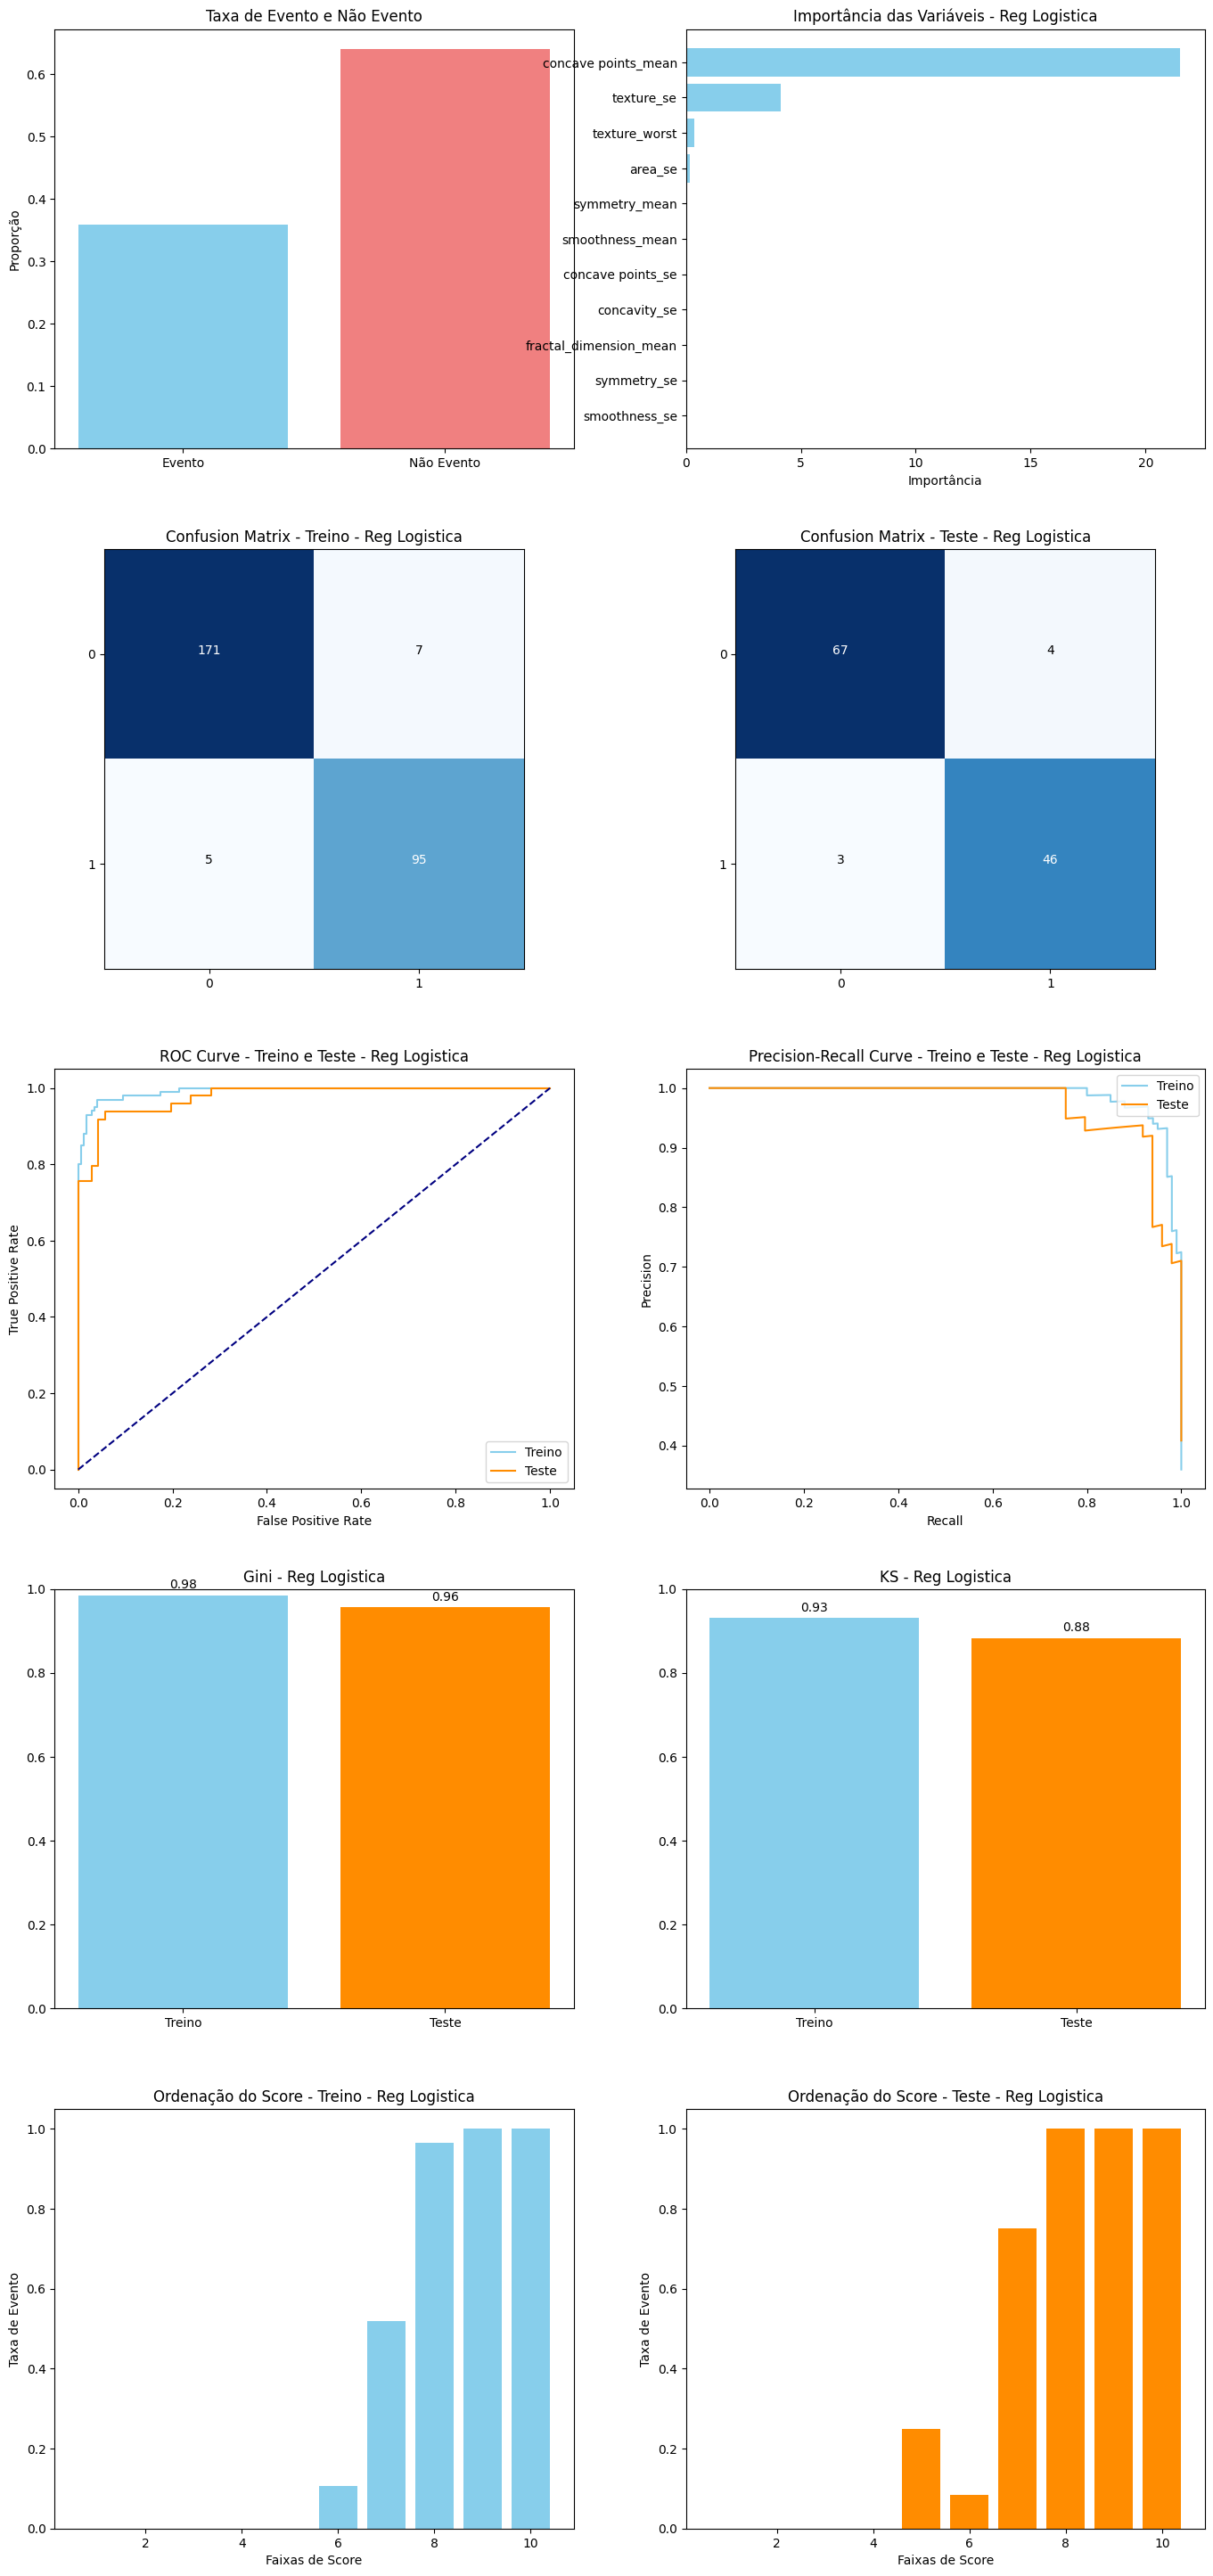

In [334]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rl_pca,nm_modelo='Reg Logistica')

####**Decision Tree Classifier**

##### **Decision Tree Classifier por Feature Importances**

---
**Treinamento**

In [27]:

X_train, X_test, y_train, y_test = train_test_split(X_fs,
                                                    y_fs,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape



# Definindo o modelo
model = DecisionTreeClassifier(random_state=42)

# Definindo os parâmetros para o grid search
param_grid = {
    'criterion':['gini','entropy'],
    'splitter':['best'],
    'max_depth': [2,4,6,8,10,15,20,30], # Profundidade máxima da árvore
    'min_samples_split': [0.01,0.015,0.02], # Número mínimo de amostras necessárias para dividir um nó interno.
    'min_samples_leaf': [0.02,0.04,0.06,0.05,0.08,0.07], # Número mínimo de amostras necessárias para estar em um nó folha.
}

# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['splitter']) * len(param_grid['criterion']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='recall',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)
predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_dt_fs = grid.best_estimator_

with open(file_folder_best_model_dt_fs, 'wb') as file:
  pickle.dump(best_model_dt_fs, file)

Total de Modelos a serem Treinados: 1440
Melhores Parâmetros:  {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 0.04, 'min_samples_split': 0.01, 'splitter': 'best'}
Melhor AUC:  0.93
Gini normalizado -->  0.86


###### **Decision Tree Classifier por Feature Importances**

---
**Métrcas**

In [336]:
# Uso da função
metrics_dt_fs = calculate_metrics('DecisionTreeClassifier',best_model_dt_fs, X_train, y_train, X_test, y_test)
plot_dt_metrics =  _plot_metrics(y_test,predictions)
metrics_dt_fs


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,0.949640,0.921569,0.940000,0.965281,0.930562,0.895056
1,DecisionTreeClassifier,Teste,0.933333,0.918367,0.918367,0.943806,0.887611,0.882437


##### **Decision Tree Classifier por Feature Importances**

---
**Avaliação**

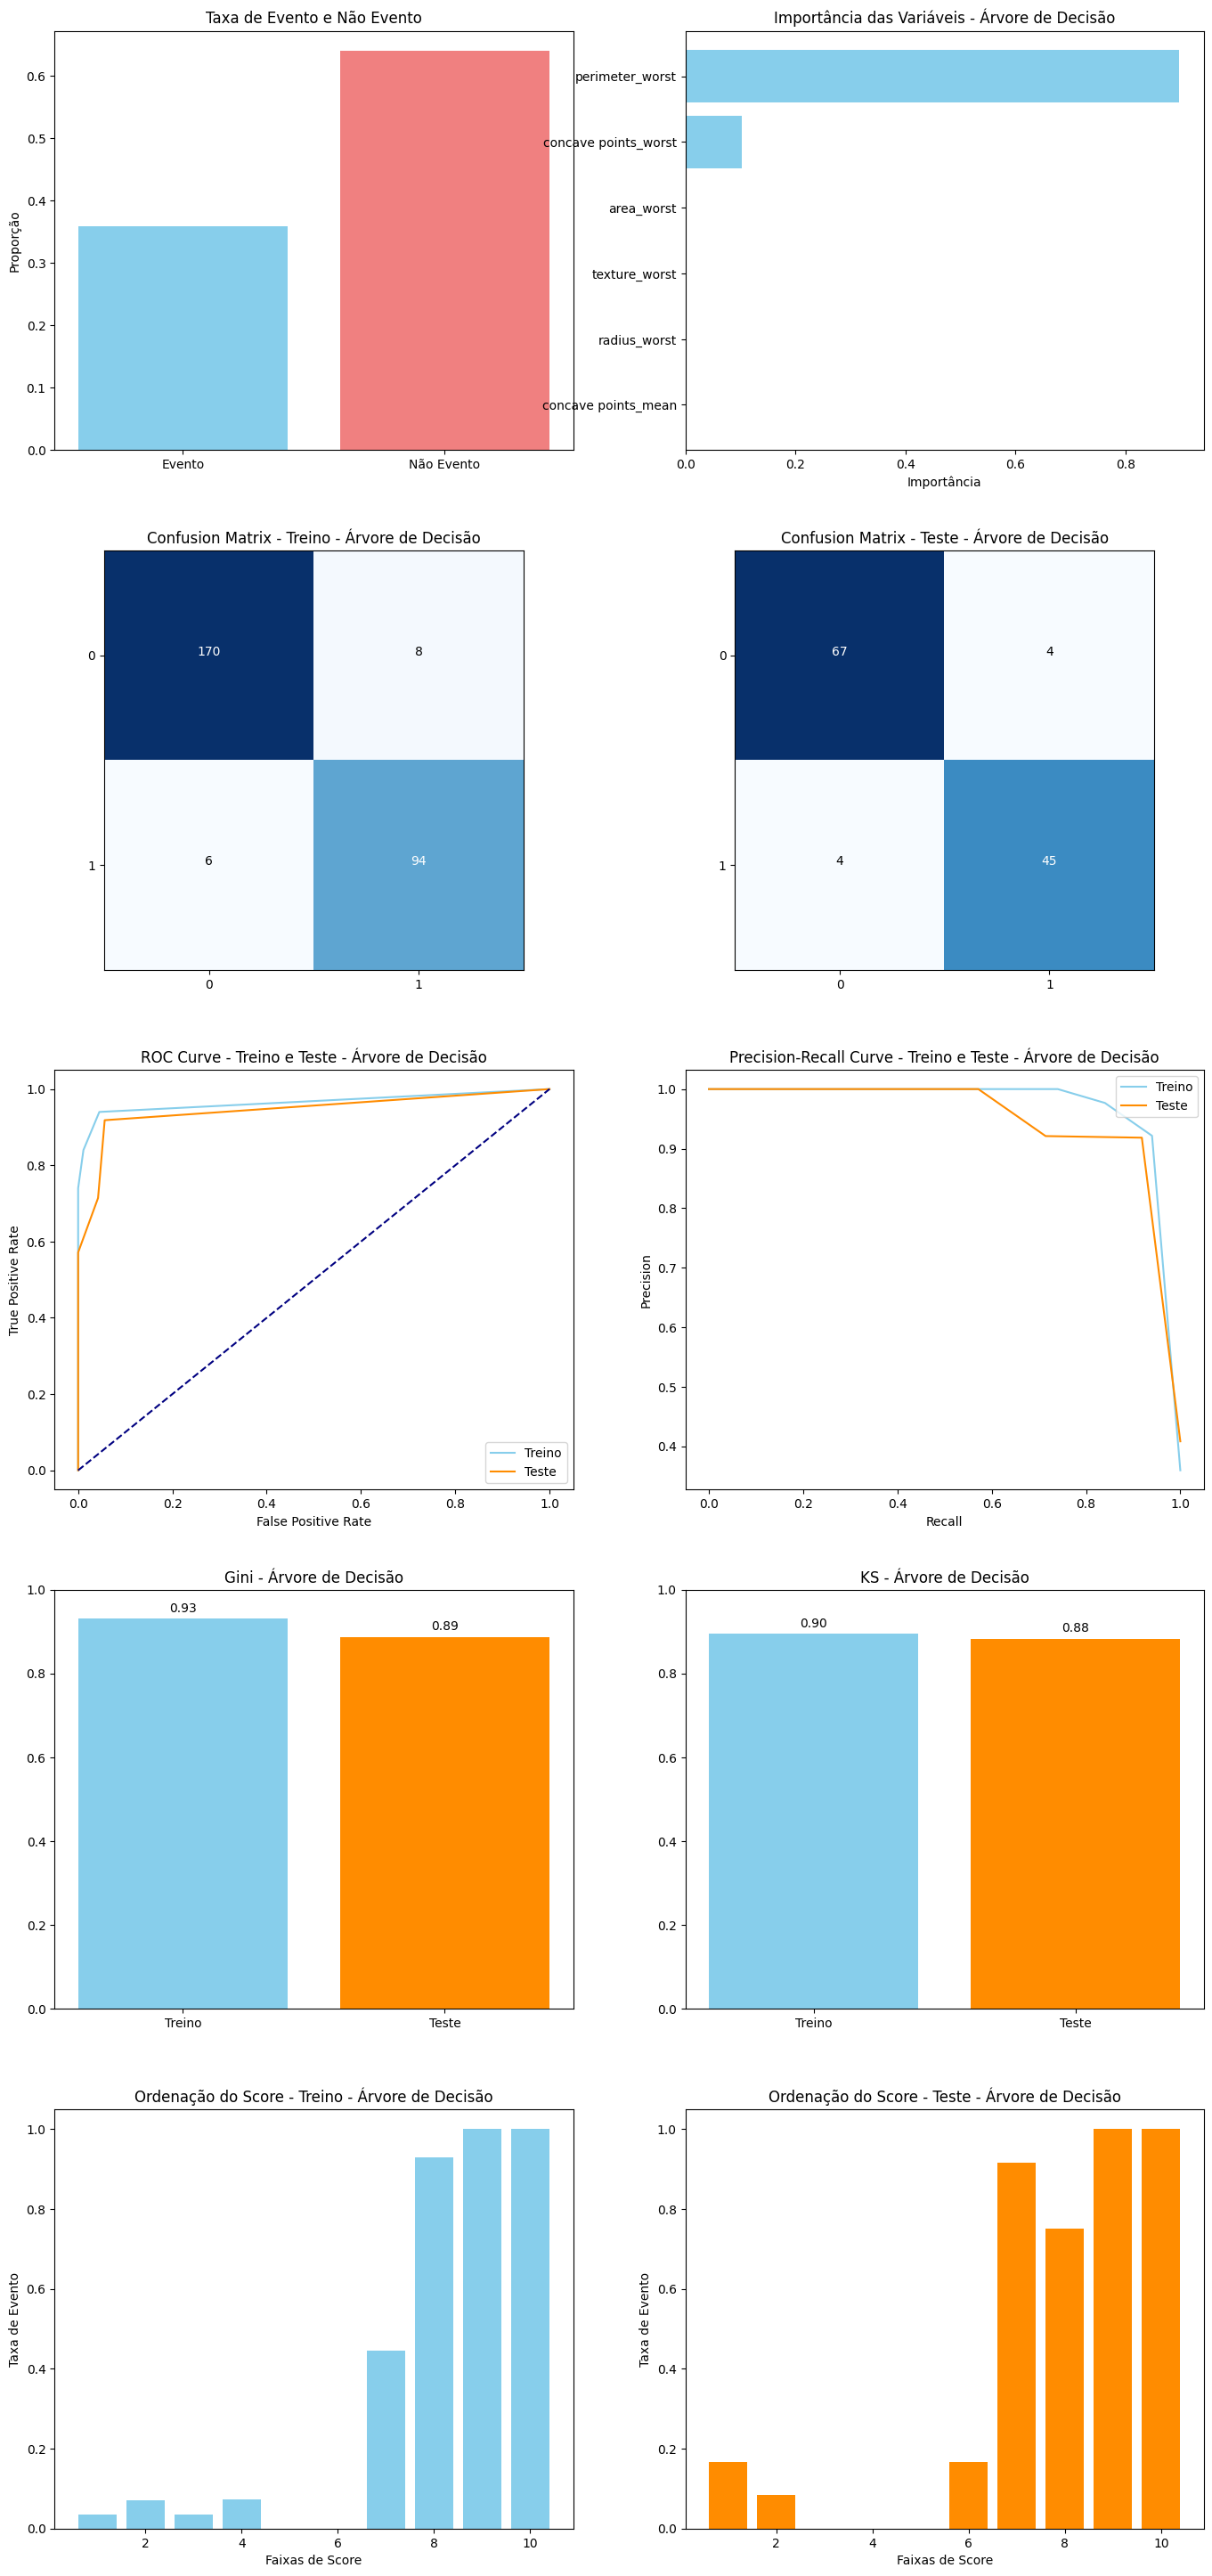

In [337]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_dt_fs,nm_modelo='Árvore de Decisão')

##### **Decision Tree Classifier por PCA**

---
**Treinamento**

In [338]:
# Separando uma amostra de 70% para treinar o modelo e 30% para testar o modelo
# Holdout 70/30 (out-of-sample)

from sklearn.model_selection import train_test_split

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X_pca,
                                                    y_pca,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((278, 11), (120, 11))

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = DecisionTreeClassifier(random_state=42)

# Definindo os parâmetros para o grid search
param_grid = {
    'criterion':['gini','entropy'],
    'splitter':['best'],
    'max_depth': [2,4,6,8,10,15,20,30], # Profundidade máxima da árvore
    'min_samples_split': [0.01,0.015,0.02], # Número mínimo de amostras necessárias para dividir um nó interno.
    'min_samples_leaf': [0.02,0.04,0.06,0.05,0.08,0.07], # Número mínimo de amostras necessárias para estar em um nó folha.
}

# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['splitter']) * len(param_grid['criterion']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='recall',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)
predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_dt_pca = grid.best_estimator_

with open(file_folder_best_model_dt_pca, 'wb') as file:
  pickle.dump(best_model_dt_pca, file)


Total de Modelos a serem Treinados: 1440
Melhores Parâmetros:  {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 0.04, 'min_samples_split': 0.01, 'splitter': 'best'}
Melhor AUC:  0.93
Gini normalizado -->  0.86


##### **Decision Tree Classifier por PCA**

---
**Métricas**

In [340]:
# Uso da função
metrics_dt_pca = calculate_metrics('DecisionTreeClassifier+PCA',best_model_dt_pca, X_train, y_train, X_test, y_test)
plot_dt_pca_metrics = _plot_metrics(y_test,predictions)
metrics_dt_pca

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier+PCA,Treino,0.942446,0.937500,0.900000,0.990843,0.981685,0.900112
1,DecisionTreeClassifier+PCA,Teste,0.900000,0.862745,0.897959,0.945243,0.890486,0.841621


##### **Decision Tree Classifier por PCA**

---
**Avaliação**

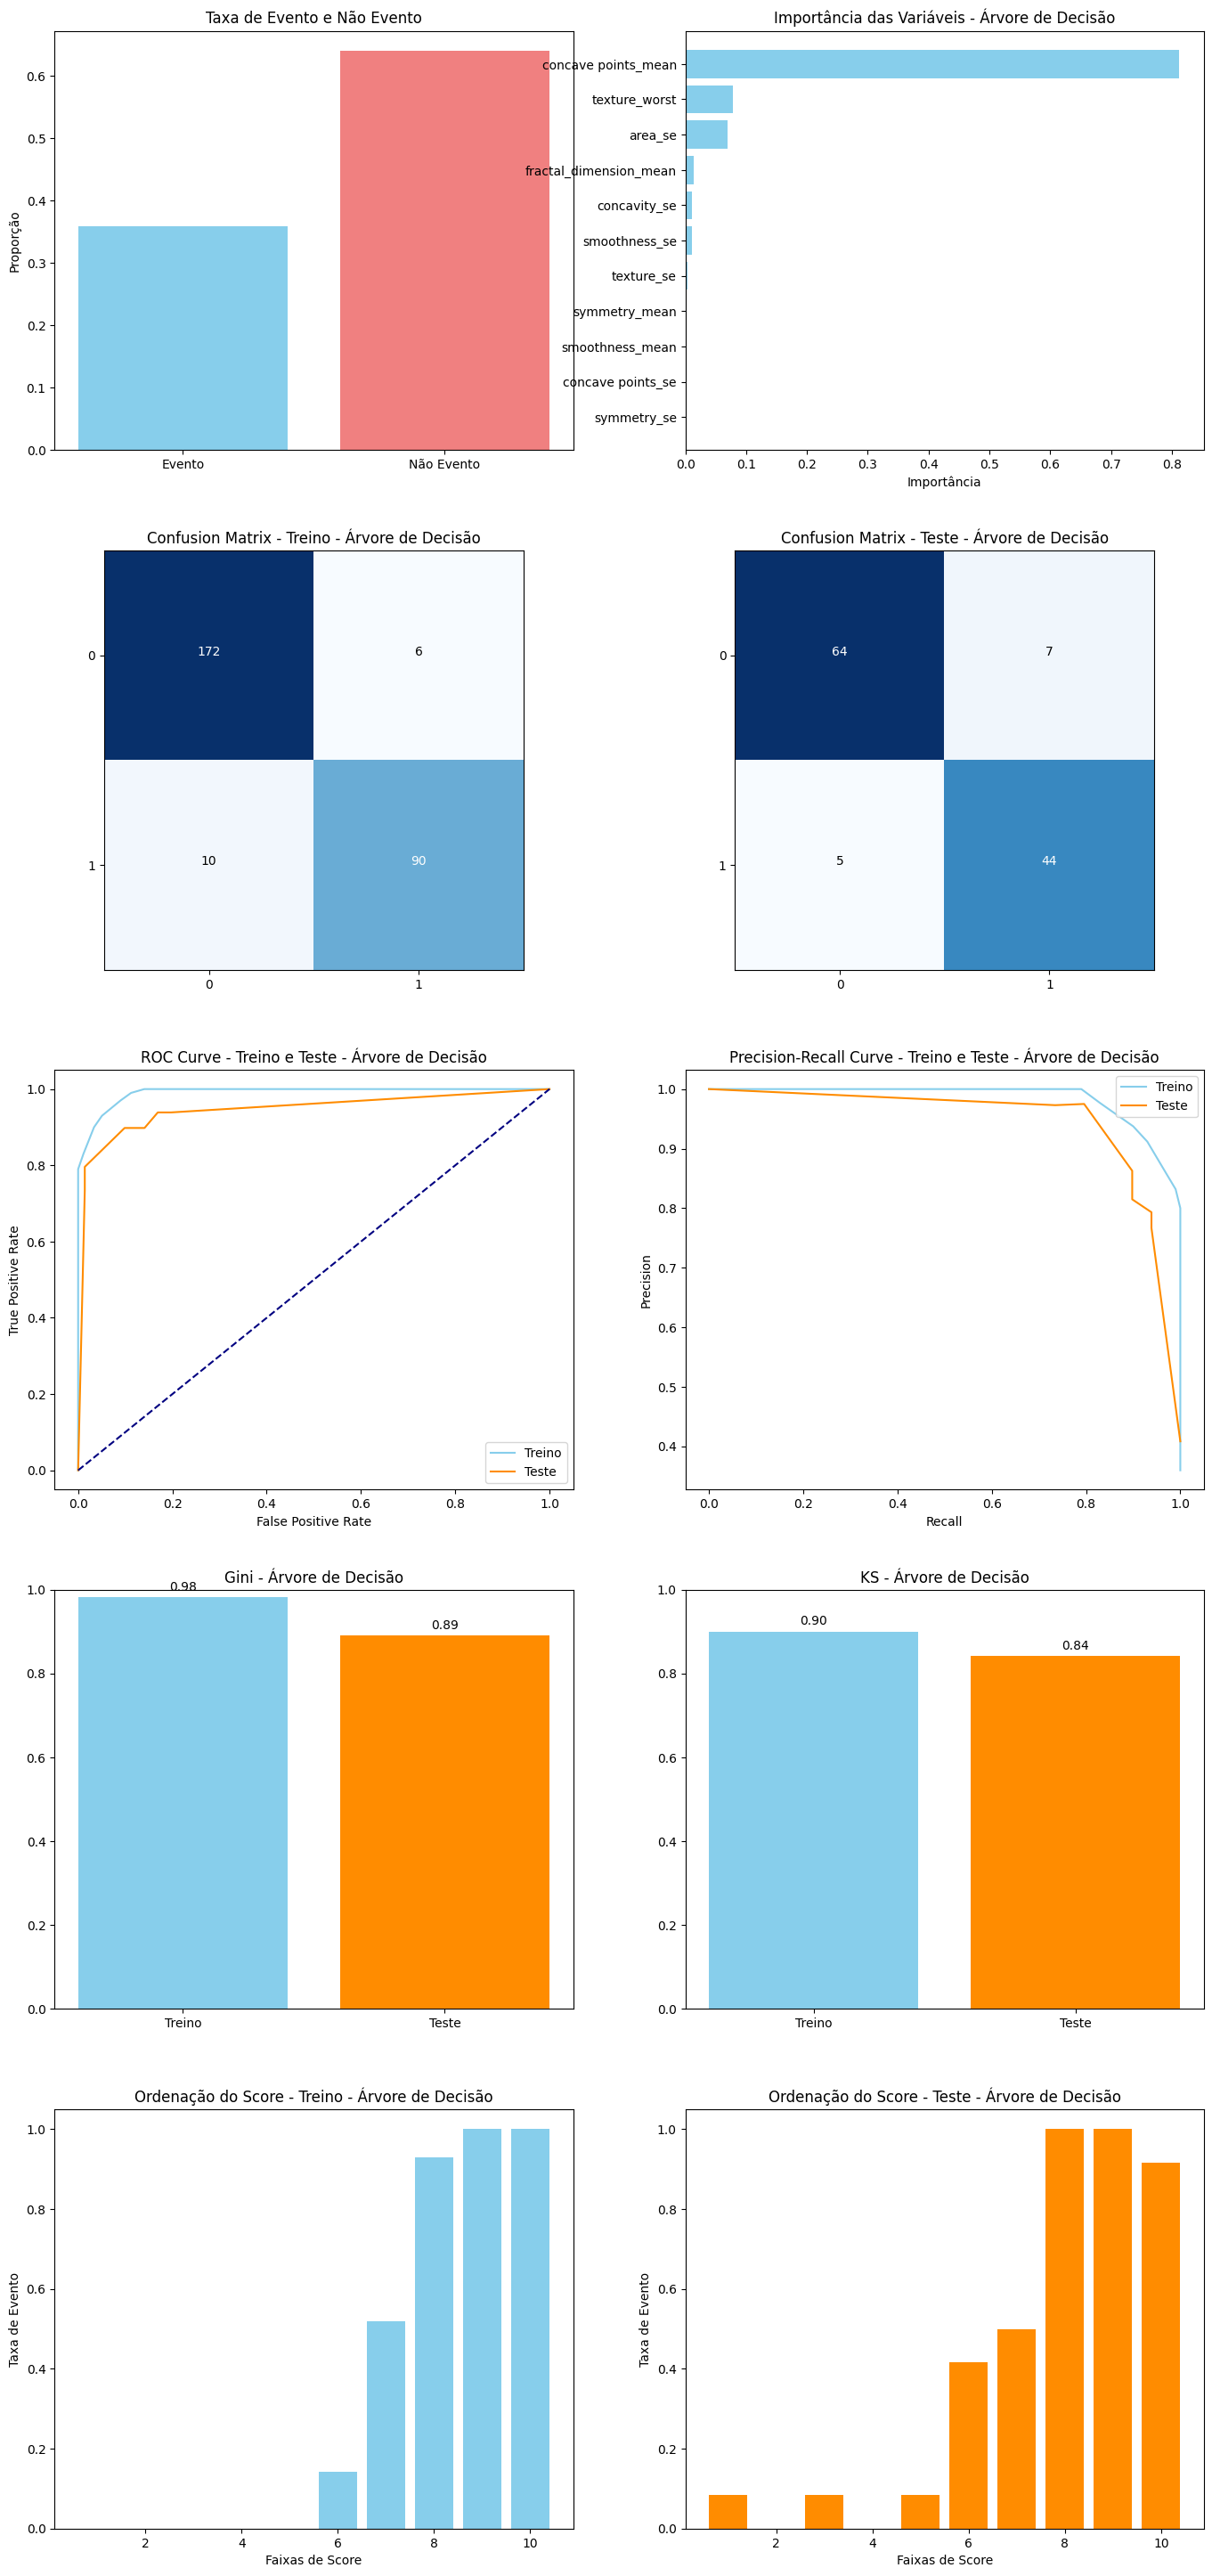

In [341]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_dt_pca,nm_modelo='Árvore de Decisão')

####**Random Forest Classifier**

##### **Random Forest Classifier por Feature Importances**

---
**Treinamento**

In [31]:
# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X_fs,
                                                    y_fs,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape



# Definindo o modelo
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [8],
    'max_depth': [8],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01],
    'bootstrap': [True, False],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='precision',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_rf_fs = grid.best_estimator_

with open(file_folder_best_model_rf_fs, 'wb') as file:
  pickle.dump(best_model_rf_fs, file)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Melhores Parâmetros:  {'bootstrap': False, 'max_depth': 8, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 8}
Melhor AUC:  0.9507936507936507
Gini normalizado -->  0.92


##### **Random Forest Classifier por Feature Importances**

---
**Métricas**

In [343]:
# Uso da função
metrics_rf_fs = calculate_metrics('RandomForestClassifier',best_model_rf_fs, X_train, y_train, X_test, y_test)
plot_rf_metrics =  _plot_metrics(y_test,predictions)
metrics_rf_fs


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.989209,0.989899,0.980000,0.998820,0.997640,0.974382
1,RandomForestClassifier,Teste,0.933333,0.955556,0.877551,0.976717,0.953435,0.902846


##### **Random Forest Classifier por Feature Importances**

---
**Avaliação**

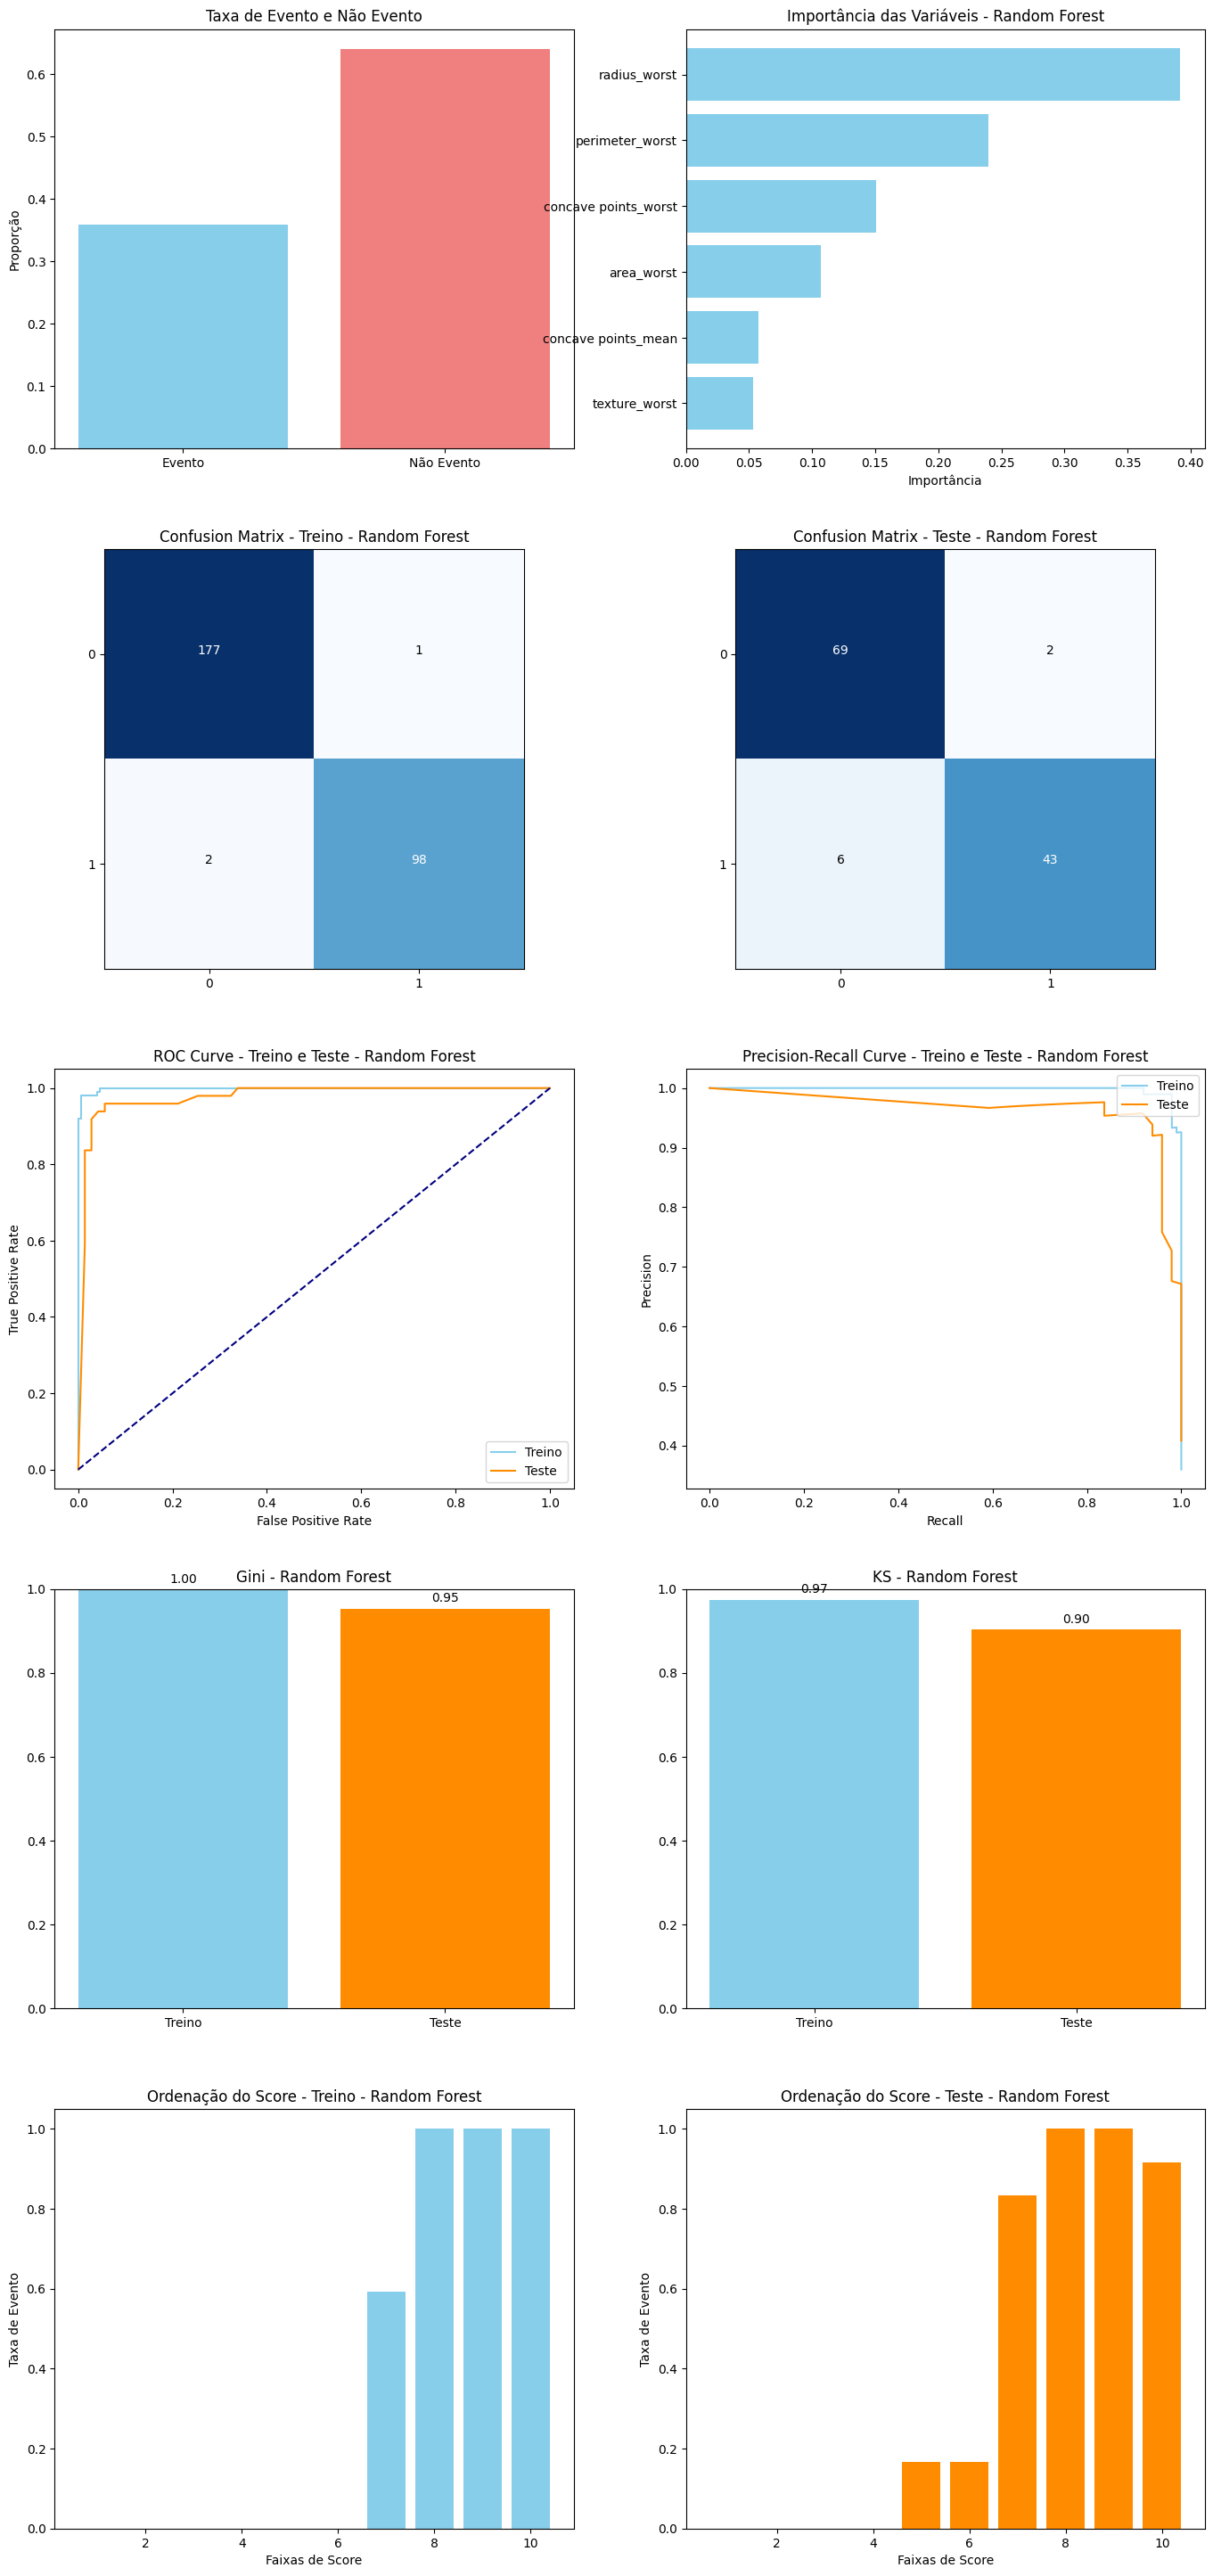

In [344]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rf_fs,nm_modelo='Random Forest')

##### **Random Forest Classifier por PCA**

---
**Treinamento**

In [32]:

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X_pca,
                                                    y_pca,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

# Definindo o modelo
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 50,100],
    'max_depth': [4],
    'min_samples_split': [0.001, 0.01],
    'min_samples_leaf': [2, 0.01],
    'bootstrap': [True, False],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='recall',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_rf_pca = grid.best_estimator_

#salva artefatos do modelo
with open(file_folder_best_model_rf_pca, 'wb') as file:
  pickle.dump(best_model_rf_pca, file)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores Parâmetros:  {'bootstrap': True, 'max_depth': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.001, 'n_estimators': 50}
Melhor AUC:  0.9199999999999999
Gini normalizado -->  0.97


##### **Random Forest Classifier por PCA**

---
**Métricas**

In [346]:
# Uso da função
metrics_rf_pca = calculate_metrics('RandomForestClassifier+PCA',best_model_rf_pca, X_train, y_train, X_test, y_test)
plot_rf_pca_metrics =  _plot_metrics(y_test,predictions)
metrics_rf_pca

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier+PCA,Treino,0.985612,1.000000,0.960000,0.999213,0.998427,0.971910
1,RandomForestClassifier+PCA,Teste,0.916667,0.914894,0.877551,0.979592,0.959184,0.846508


##### **Random Forest Classifier por PCA**

---
**Avaliação**

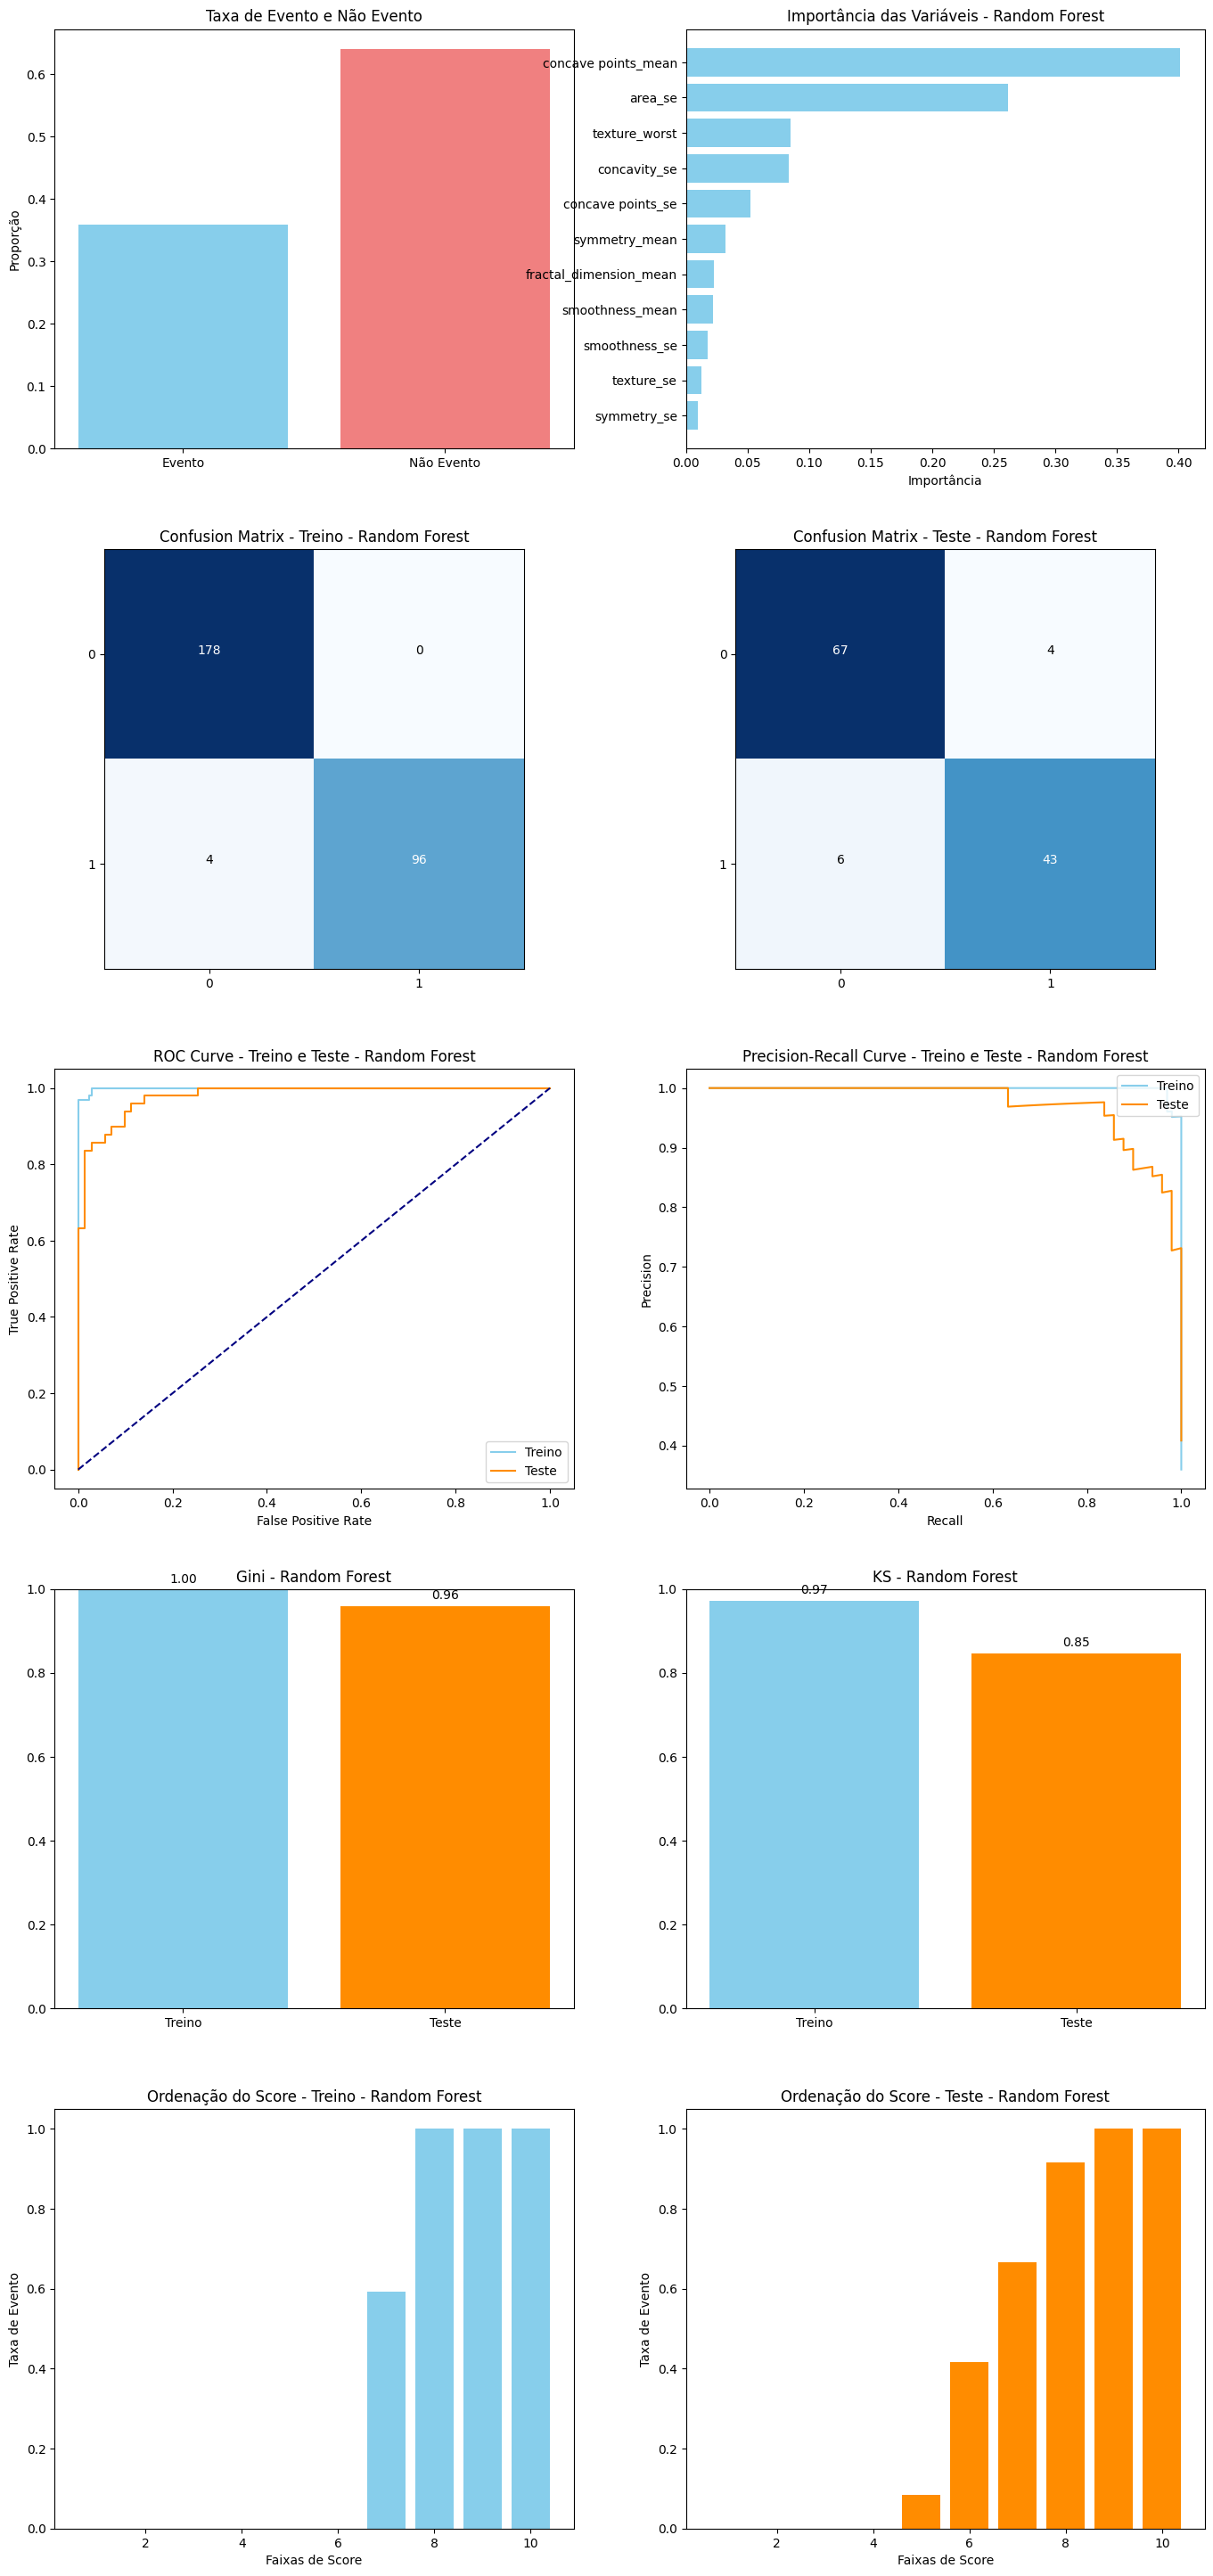

In [347]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rf_pca,nm_modelo='Random Forest')

## **EVALUATION**

Foram realizados treinamentos com três modelos de Machine Learning:

1. Random Forest
2. Logistic Regression
3. Decision Tree Classifier

No entanto, o destaque dessa etapa reside na seleção de features, onde empregamos duas abordagens distintas para otimizar o desempenho dos modelos.

* A primeira abordagem envolve a seleção de features por meio do GradientBoostingClassifier, que é uma técnica de Feature Importance.


* A segunda abordagem utiliza a técnica de Análise de Componentes Principais (PCA), que é uma técnica de redução de dimensionalidade.


Nossa meta principal nesta etapa era realizar um comparativo abrangente entre duas abordagens de seleção de features: Feature Importance com GradientBoostingClassifier e Análise de Componentes Principais (PCA).

No entanto, é importante observar que, apesar da nossa análise, os resultados não revelaram diferenças expressivas no desempenho dos modelos.

O modelo **LogisticRegression** com feature selection por **gradient boosting** destacou-se ao apresentar o melhor desempenho, especialmente considerando as métricas: **recall e precision**.

---


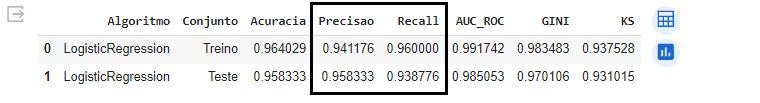

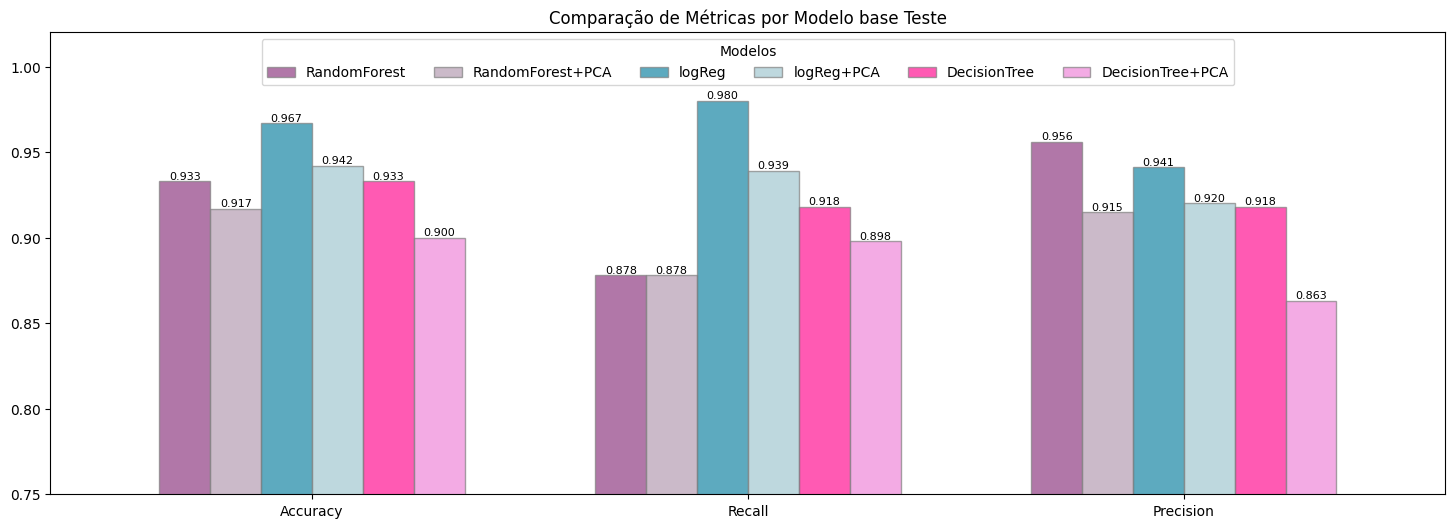

In [350]:
# métricas
models_metrics = {
    'RandomForest': [round(elem, 3 )for elem in plot_rf_metrics],
    'RandomForest+PCA': [round(elem, 3) for elem in plot_rf_pca_metrics],
    'logReg': [round(elem, 3) for elem in plot_rl_metrics],
    'logReg+PCA': [round(elem, 3) for elem in plot_rl_pca_metrics],
    'DecisionTree': [round(elem, 3) for elem in plot_dt_metrics],
    'DecisionTree+PCA': [round(elem, 3) for elem in plot_dt_pca_metrics]
}

index = ['Accuracy', 'Recall','Precision']
df_scores = pd.DataFrame(data=models_metrics, index=index)

colors = ['#903E83', '#B59DB2', '#1986A5',  '#A3C8D1', '#FF1493', '#ee88d9']

ax = df_scores.plot(kind='bar', figsize=(18, 6), ylim=(0.75, 1.02), color=colors, rot=0, title='Desempenho dos Modelos (Pontuações de Teste)', edgecolor='grey', alpha=0.7, width= 0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8)

# título e a legenda
plt.title('Comparação de Métricas por Modelo base Teste')
plt.legend(loc='upper center', ncol=6, title="Modelos")

# gráfico
plt.show()

In [351]:
metrics_rl_fs

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS,feature_selection
0,LogisticRegression,Treino,0.964029,0.941176,0.960000,0.992135,0.984270,0.933820,Feature_importante_Gradienteboost
1,LogisticRegression,Teste,0.966667,0.941176,0.979592,0.985628,0.971256,0.937338,Feature_importante_Gradienteboost


In [352]:
metrics_rf_fs

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.989209,0.989899,0.980000,0.998820,0.997640,0.974382
1,RandomForestClassifier,Teste,0.933333,0.955556,0.877551,0.976717,0.953435,0.902846


##**DEPLOYMENT**

em construção

In [34]:
df_train_00_s = df_train_00.copy()
df_test_00_s = df_test_00.copy()

In [35]:
# Carregar lista de variáveis que foram excluidas por execesso de nulos
with open(file_folder_pkl_fdrop_nullvars, 'rb') as f:
    loaded_drop_null_feat = pickle.load(f)
loaded_drop_null_feat

['Unnamed: 32']

In [36]:
# Retirando as variáveis excluídas por nulos
df_ss_train_01 = df_train_00_s.drop(axis=1,columns=loaded_drop_null_feat)
df_ss_test_01 = df_test_00_s.drop(axis=1,columns=loaded_drop_null_feat)

In [37]:
# Retirar ID e Target das tabelas (para escoragem não é necessário e em produção não teremos target)
df_ss_train_02 = df_ss_train_01.drop(axis=1, columns=['id','diagnosis'])
df_ss_test_02 = df_ss_test_01.drop(axis=1, columns=['id','diagnosis'])



In [38]:
# Carregar as medias das variaveis da base de treino
with open(file_folder_pkl_fillna, 'rb') as f:
  loaded_means = pickle.load(f)

def pod_custom_fillna_prod(df, means):
  df.replace(-1, np.nan, inplace=True)
  for col, mean_value in means.items():
      df[col].fillna(mean_value, inplace=True)

  categorical_cols = df.select_dtypes(include=['object']).columns
  df[categorical_cols] = df[categorical_cols].fillna('POD_VERIFICAR')

  return df

# Aplicar imputação de nulos na base de treino
df_ss_train_03 = pod_custom_fillna_prod(df_ss_train_02,loaded_means)

# Aplicar imputação de nulos na base de teste
df_ss_test_03 = pod_custom_fillna_prod(df_ss_test_02,loaded_means)

In [39]:
# Carregar os encoders e a lista de colunas
with open(file_folder_pkl_labelenc, 'rb') as f:
    loaded_data = pickle.load(f)

loaded_encoders = loaded_data['encoders']
loaded_columns = loaded_data['columns']

# Aplicando para base de treino
for col in loaded_columns:
    if col in loaded_encoders:
        # Transforma a coluna usando o encoder carregado
        df_ss_train_03[col] = loaded_encoders[col].transform(df_ss_train_03[col])

# Aplicando para base de teste
for col in loaded_columns:
    if col in loaded_encoders:
        # Transforma a coluna usando o encoder carregado
        df_ss_test_03[col] = loaded_encoders[col].transform(df_ss_test_03[col])


In [40]:
# Carregar o encoder e a lista de colunas
with open(file_folder_pkl_onehotenc, 'rb') as f:
    loaded_data = pickle.load(f)

loaded_encoder = loaded_data['encoder']
loaded_columns = loaded_data['columns']

# Aplicando para base completa de treino
encoded_data_test = loaded_encoder.transform(df_ss_train_03[loaded_columns])
encoded_cols_test = loaded_encoder.get_feature_names_out(loaded_columns)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_cols_test, index=df_ss_train_03.index)
df_ss_train_04 = pd.concat([df_ss_train_03.drop(loaded_columns, axis=1), encoded_df_test], axis=1)

# Aplicando para base de teste
encoded_data_test = loaded_encoder.transform(df_ss_test_03[loaded_columns])
encoded_cols_test = loaded_encoder.get_feature_names_out(loaded_columns)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_cols_test, index=df_ss_test_03.index)
df_ss_test_04 = pd.concat([df_ss_test_03.drop(loaded_columns, axis=1), encoded_df_test], axis=1)

In [41]:
df_ss_train_05 = df_ss_train_04.copy()
df_ss_test_05 = df_ss_test_04.copy()

In [42]:
# Carregar o scaler
with open(file_folder_pkl_scaler, 'rb') as f:
    loaded_scaler = pickle.load(f)

# Aplicando na base de treino
df_ss_train_05_scaled = loaded_scaler.transform(df_ss_train_05)
df_ss_train_06 = pd.DataFrame(df_ss_train_05_scaled, columns=df_ss_train_05.columns, index=df_ss_train_05.index)


# Aplicando na base de teste
df_ss_test_05s = loaded_scaler.transform(df_ss_test_05)
df_ss_test_06 = pd.DataFrame(df_ss_test_05s, columns=df_ss_test_05.columns, index=df_ss_test_05.index)



In [43]:
# Carregar lista de variáveis que passaram pelo Feature Sepection (utilizadas no treinamento do modelo)
with open(file_folder_pkl_list_features, 'rb') as f:
    loaded_features = pickle.load(f)

loaded_features

['concave points_mean',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'concave points_worst']

In [44]:
abt_train_fs = df_ss_train_05[loaded_features]
abt_test_fs = df_ss_test_05[loaded_features]

In [45]:
# Carregando modelo campeão

with open('/content/drive/MyDrive/EDA/exame_mama/model/best_model_rl_fs.pkl', 'rb') as f:
  loaded_model = pickle.load(f)

loaded_model

LogisticRegression(C=2.0, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear', tol=0.001)

In [49]:
# Escorando base de treino

predprob = loaded_model.predict_proba(abt_train_fs)
abt_train['score_1']=predprob[:,1]

predict = loaded_model.predict(abt_train_fs)
abt_train['class']=predict

# Escorando base de teste

predprob = loaded_model.predict_proba(abt_test_fs)
abt_test['score_1']=predprob[:,1]

predict = loaded_model.predict(abt_test_fs)
abt_test['class']=predict

In [47]:
abt_train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,id,diagnosis,score_1,class
149,13.740,17.91,88.12,585.0,0.07944,0.06376,0.02881,0.01329,0.1473,0.05580,...,0.09711,0.18240,0.15640,0.06019,0.2350,0.07014,869931,0,0.068046,0
124,13.370,16.39,86.10,553.5,0.07115,0.07325,0.08092,0.02800,0.1422,0.05823,...,0.10250,0.25310,0.33080,0.08978,0.2048,0.07628,865468,0,0.059386,0
421,14.690,13.98,98.22,656.1,0.10310,0.18360,0.14500,0.06300,0.2086,0.07406,...,0.13120,0.36350,0.32190,0.11080,0.2827,0.09208,906564,0,0.129524,0
195,12.910,16.33,82.53,516.4,0.07941,0.05366,0.03873,0.02377,0.1829,0.05667,...,0.10970,0.15060,0.17640,0.08235,0.3024,0.06949,875878,0,0.036680,0
545,13.620,23.23,87.19,573.2,0.09246,0.06747,0.02974,0.02443,0.1664,0.05801,...,0.12160,0.15170,0.10490,0.07174,0.2642,0.06953,922576,0,0.226815,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980,...,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840,859711,0,0.000730,0
106,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520,...,0.16880,0.26600,0.28730,0.12180,0.2806,0.09097,863031,0,0.124159,0
270,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376,...,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120,8910721,0,0.023235,0
435,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544,...,0.16130,0.35680,0.40690,0.18270,0.3179,0.10550,908489,1,0.886298,1
